### Siamese GAN

image_size = 32
channels = 1


In [1]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

In [2]:
ngpu = 0
pathA = "Data/SpectrogramsA"
pathB = "Data/SpectrogramsB"
filename_gen = "TraVeLGAN/no_smoothing_with_noise_gen4layers_20epoci/TraVeLGAN-Gen.joblib"
filename_dis = "TraVeLGAN/no_smoothing_with_noise_gen4layers_20epoci/TraVeLGAN-Dis.joblib"
filename_sim = "TraVeLGAN/no_smoothing_with_noise_gen4layers_20epoci/TraVeLGAN-Siam.joblib"
workers = 2
batch_size = 32

image_size = 32

# channels nr for input images
nc = 1
# size of feature maps in generator
ngf = 64
# size of feature maps in discriminator
ndf = 64
# length of latent vector
lenvec = 128

num_epochs = 20
lr = 0.0002
lrD = 0.000001
beta1 = 0.5

def find_classes(directory:str):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_index = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_index

In [3]:
class MyImageFolder(torch.utils.data.Dataset):
    def __init__(self, directory:str, transform=None):

        self.paths = list(pathlib.Path(directory).glob('*/*.jpg')) * 3

        self.transform = transform
        self.classes, self.class_to_index = find_classes(directory)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_index = self.class_to_index[class_name]

        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

transform = torchvision.transforms.Compose([
            #torchvision.transforms.RandomResizedCrop(image_size),
            #torchvision.transforms.Resize(64),
            #torchvision.transforms.RandomCrop(64),
            # TODO test this
            #torchvision.transforms.RandomResizedCrop(image_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            # torchvision.transforms.RandomHorizontalFlip(p=0.3)

            torchvision.transforms.ToTensor(),  # imaginile sunt normalizate intre [0, 1]
            torchvision.transforms.Normalize(0.5, 0.5),  # imaginile sunt normalizate intre [-1, 1]
        ])


In [4]:
train_data_A = MyImageFolder(directory=pathA, transform=transform)
train_data_B = MyImageFolder(directory=pathB, transform=transform)

dataloader_A = torch.utils.data.DataLoader(train_data_A, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_B = torch.utils.data.DataLoader(train_data_B, batch_size=batch_size, shuffle=True, num_workers=2)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [5]:
'''
Gaussian distribution (also known as normal distribution) is a bell-shaped curve, and it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.
'''
class GaussianNoise(torch.nn.Module):
    def __init__(self, std=0.1, decay=0):
        super().__init__()
        self.std = std
        self.decay = decay

    def step(self):
        self.std = max(self.std - self.decay, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [6]:
'''
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [7]:
# TODO train cu si fara GaussianNoise()

# maybe ReLU in generator
generator = torch.nn.Sequential(

    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),

    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),


    # upsampling
    torch.nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),


    torch.nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh(),
    # ngf x 32 x 16

)

generator.apply(weights_init)




Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

In [8]:
# Siamese model

siamese = torch.nn.Sequential(
    # conv2d
    # conv2d
    # conv2d

    # 1 x 32 x 16
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 16 x 8

    torch.nn.Conv2d(ngf, ngf, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 8 x 8

    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 8 x 4

    torch.nn.Flatten(),
    # ngf*2*8*4
    torch.nn.Linear(ngf * 64, lenvec)
)

In [9]:
# Discriminator model
# TODO train cu si fara GaussianNoise()
# TODO de incercat torch.nn.AvgPool2d(kernel_size=4, stride=2, padding=1) in loc de batchnorm
# TODO incercat cu torch.nn.Dropout(p=0.3) in loc de BatchNorm2d
discriminator = torch.nn.Sequential(
    # nc x 32 x 32

    torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
    torch.nn.BatchNorm2d(ndf),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf x 16 x 16

    torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
    torch.nn.BatchNorm2d(ndf * 2),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf*2 x 8 x 8

    torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
    torch.nn.BatchNorm2d(ndf * 4),
    torch.nn.LeakyReLU(0.2, inplace=True),
    # ndf*4 x 4 x 4

    torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
    torch.nn.Sigmoid(),
    # 1 x 1 x 1

)
discriminator.apply(weights_init)



Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (10): Sigmoid()
)

In [10]:
class IdentityLoss(torch.nn.Module):
    def __init__(self):
        super(IdentityLoss, self).__init__()

    def forward(self, real, generated):
        identity_loss = torch.nn.functional.l1_loss(real, generated)
        return identity_loss

class CosineSimilarityLoss(torch.nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, a, b):
        a_normalized = torch.nn.functional.normalize(a, dim=1)
        b_normalized = torch.nn.functional.normalize(b, dim=1)
        cos_sim = torch.mean(torch.nn.functional.cosine_similarity(a_normalized, b_normalized, dim=1))
        return cos_sim

class SiameseLoss(torch.nn.Module):
    def __init__(self, margin):
        super(SiameseLoss, self).__init__()
        self.margin = margin

    def forward(self, a1, a2):
        distances = torch.sqrt(torch.sum((a1 - a2) ** 2, dim=-1, keepdim=True))
        hinge_loss = torch.square(torch.maximum((self.margin - distances), torch.tensor(0)))
        loss = torch.mean(hinge_loss)
        return loss

In [11]:
adversarial_loss = torch.nn.BCELoss()
#contrastive_loss = torch.nn.CosineEmbeddingLoss(margin=1.0)
identity_loss = IdentityLoss()
cossine_loss = CosineSimilarityLoss()
siamese_loss = SiameseLoss(1)

fixed_noise = torch.randn(batch_size, nc, image_size, image_size, device=device)
different_classes = -1
same_class = 1
real_label = 0
fake_label = 1

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999))
scheduler_gen = ReduceLROnPlateau(gen_optimizer, patience=1, factor=0.1, min_lr=0.00000001, verbose=True)
#scheduler_dis = ReduceLROnPlateau(dis_optimizer, patience=1, factor=0.1, min_lr=0.0000001)

In [12]:
def normalize(x, minim, maxim):
    return (x - minim) / (maxim - minim)

# def smooth_label(label):
#     arr = torch.rand((b_size,), dtype=torch.float, device=device)
#     if label == 1:
#         for i in range(arr.shape[0]):
#             arr[i] = normalize(arr[i], 0.7, 1.2)
#     else:
#         for i in range(arr.shape[0]):
#             arr[i] = normalize(arr[i], 0.0, 0.3)
#     return arr

def slice_images(batch):
    part1 = batch[:, :, :, :batch.shape[3] // 2].clone()
    part2 = batch[:, :, :, batch.shape[3] // 2 :].clone()
    return part1, part2

def assemble_images(part1, part2):
    image = torch.cat([part1, part2], dim=3)
    return image

img_lists = []
gen_losses = []
dis_losses = []
iters = 0


In [13]:
def traind_discriminator(A, B):
    A1, A2 = slice_images(A)
    A_b_size = A1.size(0)
    B_b_size = B.size(0)
    gen_A1 = generator(A1)
    gen_A2 = generator(A2)
    AB = assemble_images(gen_A1, gen_A2)
    output_AB = discriminator(AB.detach()).view(-1)
    output_B = discriminator(B).view(-1)

    label_fake = torch.full((B_b_size,), fake_label, dtype=torch.float, device=device)
    zero = torch.full((B_b_size,), 0, dtype=torch.float, device=device)
    d_loss_real = torch.mean(torch.max(label_fake + output_B, zero))

    zero = torch.full((A_b_size,), 0, dtype=torch.float, device=device)
    label_f = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
    d_loss_fake = torch.mean(torch.max(label_f - output_AB, zero))

    d_total_loss = (d_loss_real + d_loss_fake) / 2

    dis_optimizer.zero_grad()
    d_total_loss.backward()
    dis_optimizer.step()

    return d_loss_real, d_loss_fake

In [ ]:
for epoch in range(num_epochs):
    g_total_loss = 0
    d_total_loss = 0
    dis_b = 0
    dis_ab = 0

    torch.autograd.set_detect_anomaly(True)
    for i, (data_A, data_B) in tqdm(enumerate(zip(dataloader_A, dataloader_B))):

        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)
        # data[0] sunt imaginile
        # data[1] sunt labelurile

        A1, A2 = slice_images(real_A)
        B1, B2 = slice_images(real_B)

        A_b_size = A1.size(0)  # batch size
        B_b_size = B1.size(0)

        if i % 1 == 0:

            # Training the discriminator
            gen_A1 = generator(A1)
            gen_A2 = generator(A2)
            gen_B1 = generator(B1)
            gen_B2 = generator(B2)

            # identity mapping loss
            id_loss = (identity_loss(B1, gen_B1) + identity_loss(B2, gen_B2)) / 2
            if i % 60 == 0: print(f"Id loss {id_loss:.4f}")

            AB = assemble_images(gen_A1, gen_A2)

            output_AB = discriminator(AB.detach()).view(-1)
            output_B = discriminator(real_B).view(-1)
            if i % 60 == 0: print(output_AB, output_B)


            label_fake = torch.full((B_b_size,), fake_label, dtype=torch.float, device=device)
            zero = torch.full((B_b_size,), 0, dtype=torch.float, device=device)
            #d_loss_real = adversarial_loss(output_B, label_real)
            d_loss_real = torch.mean(torch.max(label_fake + output_B, zero))
            if i % 60 == 0: print(f"D loss real: {d_loss_real:.4f}")

            label_real = torch.full((A_b_size,), real_label, dtype=torch.float, device=device)
            label_f = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
            zero = torch.full((A_b_size,), 0, dtype=torch.float, device=device)
            #d_loss_fake = adversarial_loss(output_AB, label_fake)
            d_loss_fake = torch.mean(torch.max(label_f - output_AB, zero))
            if i % 60 == 0: print(f"D loss fake: {d_loss_fake:.4f}")
            # Train siamese
            siamese.zero_grad()
            siamese_AB1 = siamese(gen_A1)
            siamese_AB2 = siamese(gen_A2)
            siamese_A1 = siamese(A1)
            siamese_A2 = siamese(A2)

            # travel loss + siamese loss
            # t1 = reduce_mean(((siamese_A1 - siamese_A2) - (siamese_AB1 - siamese_AB2)) ** 2)
            # t2 = reduce_mean( reduce_sum( - (l2_norm(siamese_A1 - siamese_AB2) * l2_norm(siamese_AB1 -siamese_AB2))))
            t_loss = cossine_loss((siamese_A1 - siamese_A2), (siamese_AB1 - siamese_AB2))
            #t_loss.backward()
            # asta cred ca e contrastive loss with a twist

            # s_loss = reduce_mean(square(maximum(delta - s_loss), 0)
            s_loss = siamese_loss(siamese_A1, siamese_A2)
            ts_loss = 1 - t_loss + s_loss
            if i % 60 == 0: print(f"Ts loss {ts_loss:.4f}")

            label_gen = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
            disc = discriminator(AB.detach()).view(-1)
            #g_loss = adversarial_loss(disc, label_gen)
            g_loss = torch.mean(-(label_gen - disc))
            if i % 60 == 0: print(f"G loss :{g_loss:.4f}")
            # g_loss = reduce_mean( - output_AB)

            # rd_loss = reduce_mean(maximum(1 - real_B, 0)
            # fd_loss = reduce_mean(maximum(1 + fake, 0)
            # rd_loss.backward()
            # fd_loss.backward()

            d_total_loss = (d_loss_real + d_loss_fake) / 2
            g_total_loss = g_loss + 10. * ts_loss + 0.5 * id_loss

            dis_b = output_B.mean().item()
            dis_ab = output_AB.mean().item()

            gen_optimizer.zero_grad()
            g_total_loss.backward()
            gen_optimizer.step()

            dis_optimizer.zero_grad()
            d_total_loss.backward()
            dis_optimizer.step()

        else:
            d_loss_real, d_loss_fake = traind_discriminator(real_A, real_B)
            d_total_loss = (d_loss_real + d_loss_fake) / 2

        if i % 60 == 0:
            print(f"[{epoch}/{num_epochs - 1}] [{i}/{len(dataloader_A) - 1}]\tLoss_dis: {d_total_loss.item():.4f}\tLoss_gen: {g_total_loss.item():.4f}\tD(x): {dis_b:.4f}\tD(G(x)): {dis_ab:.4f}")

        gen_losses.append(g_total_loss.item())
        dis_losses.append(d_total_loss.item())

        # if iters % 500 == 0 or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        with torch.no_grad():
            fake = generator(A1).detach().cpu()
        img_lists.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    scheduler_gen.step(g_total_loss.item())
    #scheduler_dis.step(d_total_loss.item())


    joblib.dump(generator, filename_gen)
    joblib.dump(discriminator, filename_dis)
    joblib.dump(siamese, filename_sim)

    gen_losses_arr = np.array(gen_losses, dtype=object)
    dis_losses_arr = np.array(dis_losses, dtype=object)
    img_arr = np.array(img_lists, dtype=object)
    np.save('TraVeLGAN/no_smoothing_with_noise_gen4layers_20epoci/TraVeLGAN-gen_losses.npy', gen_losses_arr)
    np.save('TraVeLGAN/no_smoothing_with_noise_gen4layers_20epoci/TraVeLGAN-dis_losses.npy', dis_losses_arr)
    np.save('TraVeLGAN/no_smoothing_with_noise_gen4layers_20epoci/TraVeLGAN-imgs.npy', img_arr)


0it [00:00, ?it/s]

Id loss 0.9873
tensor([0.6669, 0.6793, 0.7028, 0.2617, 0.6767, 0.7001, 0.6716, 0.6767, 0.6765,
        0.6690, 0.6767, 0.6540, 0.7239, 0.7042, 0.6767, 0.6821, 0.6315, 0.6602,
        0.7089, 0.6976, 0.8294, 0.6064, 0.6767, 0.6835, 0.6783, 0.6767, 0.6797,
        0.5933, 0.6810, 0.6762, 0.6972, 0.6354], grad_fn=<ViewBackward0>) tensor([0.6389, 0.6253, 0.6374, 0.6530, 0.6351, 0.6359, 0.6351, 0.6843, 0.6351,
        0.6351, 0.6560, 0.6351, 0.6167, 0.6351, 0.6351, 0.5530, 0.6873, 0.6351,
        0.6351, 0.6351, 0.6621, 0.6351, 0.9523, 0.6173, 0.5622, 0.6377, 0.6351,
        0.9902, 0.8564, 0.8415, 0.6351, 0.6351], grad_fn=<ViewBackward0>)
D loss real: 1.6687
D loss fake: 0.3340
Ts loss 1.2527
G loss :-0.3340


1it [00:00,  2.18it/s]

[0/19] [0/538]	Loss_dis: 1.0014	Loss_gen: 12.6861	D(x): 0.6687	D(G(x)): 0.6660


60it [00:20,  3.06it/s]

Id loss 0.8964
tensor([0.6003, 0.7447, 0.7435, 0.7448, 0.7368, 0.8166, 0.7551, 0.7454, 0.5793,
        0.7449, 0.8746, 0.7427, 0.7534, 0.7455, 0.6900, 0.9864, 0.7442, 0.7179,
        0.6965, 0.8007, 0.7130, 0.7387, 0.9849, 0.5956, 0.6956, 0.7442, 0.6517,
        0.7442, 0.8412, 0.7527, 0.7442, 0.7540], grad_fn=<ViewBackward0>) tensor([0.4655, 0.4425, 0.9546, 0.4425, 0.9801, 0.7362, 0.4425, 0.4425, 0.4425,
        0.4732, 0.4203, 0.9696, 0.4376, 0.4425, 0.4465, 0.4425, 0.4441, 0.4425,
        0.4834, 0.4425, 0.4392, 0.4425, 0.4425, 0.4425, 0.5667, 0.3914, 0.4452,
        0.4638, 0.4425, 0.4425, 0.4425, 0.7659], grad_fn=<ViewBackward0>)
D loss real: 1.5163
D loss fake: 0.2524
Ts loss 0.4789
G loss :-0.2524


61it [00:20,  3.12it/s]

[0/19] [60/538]	Loss_dis: 0.8843	Loss_gen: 4.9846	D(x): 0.5163	D(G(x)): 0.7476


120it [00:37,  4.33it/s]

Id loss 0.8566
tensor([0.7860, 0.8327, 0.8944, 0.8336, 0.8339, 0.8339, 0.8356, 0.8253, 0.9444,
        0.8339, 0.6587, 0.8339, 0.6861, 0.9750, 0.8438, 0.6501, 0.8339, 0.8339,
        0.8539, 0.7995, 0.8342, 0.8339, 0.8339, 0.8337, 0.8338, 0.8354, 0.8321,
        0.8329, 0.8718, 0.8321, 0.9833, 0.8274], grad_fn=<ViewBackward0>) tensor([0.2696, 0.2526, 0.3194, 0.2649, 0.3003, 0.2573, 0.5117, 0.2696, 0.2545,
        0.2713, 0.1750, 0.2638, 0.2696, 0.2696, 0.2805, 0.2172, 0.1210, 0.5844,
        0.3232, 0.2651, 0.2696, 0.3288, 0.4556, 0.6266, 0.3213, 0.2696, 0.0904,
        0.2710, 0.3187, 0.2512, 0.2516, 0.2723], grad_fn=<ViewBackward0>)
D loss real: 1.2959
D loss fake: 0.1685
Ts loss 0.4802
G loss :-0.1685


121it [00:37,  4.14it/s]

[0/19] [120/538]	Loss_dis: 0.7322	Loss_gen: 5.0619	D(x): 0.2959	D(G(x)): 0.8315


180it [00:54,  3.94it/s]

Id loss 0.8426
tensor([0.9780, 0.8427, 0.8433, 0.7484, 0.8420, 0.8389, 0.8643, 0.9103, 0.8405,
        0.8512, 0.8433, 0.8643, 0.8428, 0.9025, 0.8486, 0.8352, 0.8717, 0.8365,
        0.7862, 0.8316, 0.8383, 0.8416, 0.7127, 0.8409, 0.9182, 0.9086, 0.5669,
        0.8433, 0.8433, 0.8535, 0.8411, 0.8410], grad_fn=<ViewBackward0>) tensor([0.1213, 0.1213, 0.1213, 0.2364, 0.1213, 0.1390, 0.1213, 0.1213, 0.1282,
        0.9620, 0.1213, 0.1213, 0.9578, 0.1213, 0.1291, 0.1213, 0.2679, 0.1213,
        0.1213, 0.1213, 0.1611, 0.1213, 0.1213, 0.1213, 0.1212, 0.1238, 0.1213,
        0.1213, 0.1300, 0.1213, 0.1299, 0.1213], grad_fn=<ViewBackward0>)
D loss real: 1.1848
D loss fake: 0.1603
Ts loss 0.4366
G loss :-0.1603


181it [00:54,  3.66it/s]

[0/19] [180/538]	Loss_dis: 0.6725	Loss_gen: 4.6270	D(x): 0.1848	D(G(x)): 0.8397


240it [01:11,  2.96it/s]

Id loss 0.7953
tensor([0.8304, 0.8837, 0.8352, 0.9302, 0.8326, 0.8292, 0.8348, 0.8348, 0.8154,
        0.8377, 0.9853, 0.8387, 0.8501, 0.8348, 0.8362, 0.8326, 0.9673, 0.8399,
        0.8426, 0.8348, 0.8348, 0.8278, 0.8566, 0.8248, 0.8348, 0.8348, 0.7686,
        0.9669, 0.8392, 0.9672, 0.8348, 0.8860], grad_fn=<ViewBackward0>) tensor([0.1256, 0.2008, 0.1256, 0.1806, 0.1205, 0.1261, 0.1256, 0.1260, 0.1252,
        0.2854, 0.1256, 0.1033, 0.9861, 0.1607, 0.1131, 0.1256, 0.1416, 0.1256,
        0.1256, 0.1942, 0.4711, 0.1258, 0.1256, 0.1256, 0.4123, 0.2069, 0.6658,
        0.1364, 0.1604, 0.1256, 0.1256, 0.5029], grad_fn=<ViewBackward0>)
D loss real: 1.2165
D loss fake: 0.1437
Ts loss 0.2643
G loss :-0.1437


241it [01:11,  2.94it/s]

[0/19] [240/538]	Loss_dis: 0.6801	Loss_gen: 2.8971	D(x): 0.2165	D(G(x)): 0.8563


300it [01:30,  3.77it/s]

Id loss 0.7708
tensor([0.8291, 0.8306, 0.8251, 0.8273, 0.8273, 0.8284, 0.9113, 0.8276, 0.9435,
        0.8252, 0.9407, 0.8189, 0.8305, 0.8353, 0.8264, 0.8221, 0.7853, 0.7892,
        0.8132, 0.8272, 0.7021, 0.8236, 0.8262, 0.8286, 0.9550, 0.8853, 0.9114,
        0.8361, 0.8302, 0.8273, 0.8436, 0.8227], grad_fn=<ViewBackward0>) tensor([0.0410, 0.0680, 0.0470, 0.0422, 0.0386, 0.3708, 0.0410, 0.0413, 0.0363,
        0.0410, 0.4212, 0.0452, 0.0548, 0.0648, 0.0410, 0.0405, 0.2989, 0.1540,
        0.0639, 0.0416, 0.0410, 0.0761, 0.0410, 0.0410, 0.0426, 0.0379, 0.0410,
        0.0410, 0.0409, 0.0410, 0.2045, 0.0410], grad_fn=<ViewBackward0>)
D loss real: 1.0838
D loss fake: 0.1607
Ts loss 0.4201
G loss :-0.1607


301it [01:30,  3.77it/s]

[0/19] [300/538]	Loss_dis: 0.6223	Loss_gen: 4.4261	D(x): 0.0838	D(G(x)): 0.8393


360it [01:46,  3.70it/s]

Id loss 0.7289
tensor([0.8551, 0.7574, 0.8549, 0.8537, 0.8850, 0.8384, 0.9326, 0.7945, 0.8551,
        0.8551, 0.8982, 0.9920, 0.8496, 0.8529, 0.9717, 0.8520, 0.8556, 0.5153,
        0.8886, 0.6506, 0.7950, 0.8551, 0.8555, 0.8540, 0.8410, 0.8507, 0.9900,
        0.8551, 0.8850, 0.8371, 0.8591, 0.8398], grad_fn=<ViewBackward0>) tensor([0.0555, 0.0567, 0.0791, 0.0796, 0.0569, 0.0559, 0.0555, 0.0426, 0.0559,
        0.0555, 0.0534, 0.0555, 0.0683, 0.7283, 0.1881, 0.0541, 0.0555, 0.3103,
        0.0555, 0.0604, 0.1010, 0.0555, 0.0555, 0.0779, 0.0554, 0.0555, 0.0333,
        0.0660, 0.0555, 0.0555, 0.0561, 0.0618], grad_fn=<ViewBackward0>)
D loss real: 1.0922
D loss fake: 0.1523
Ts loss 0.3306
G loss :-0.1523


361it [01:46,  3.70it/s]

[0/19] [360/538]	Loss_dis: 0.6223	Loss_gen: 3.5177	D(x): 0.0922	D(G(x)): 0.8477


420it [02:02,  3.74it/s]

Id loss 0.6759
tensor([0.8028, 0.8618, 0.8218, 0.7992, 0.8016, 0.7981, 0.7908, 0.7849, 0.7962,
        0.3329, 0.7992, 0.7992, 0.7972, 0.7992, 0.8791, 0.7992, 0.9049, 0.8121,
        0.7953, 0.9022, 0.7874, 0.7992, 0.3429, 0.8230, 0.9936, 0.7757, 0.7992,
        0.8357, 0.5529, 0.7960, 0.7992, 0.7982], grad_fn=<ViewBackward0>) tensor([0.0722, 0.0376, 0.0722, 0.0723, 0.2437, 0.3903, 0.0720, 0.2032, 0.1812,
        0.0722, 0.0649, 0.0722, 0.0891, 0.3094, 0.0704, 0.0758, 0.0613, 0.0745,
        0.0722, 0.0724, 0.0938, 0.1244, 0.0825, 0.0721, 0.0748, 0.1009, 0.0722,
        0.0743, 0.2140, 0.0284, 0.0696, 0.0771], grad_fn=<ViewBackward0>)
D loss real: 1.1082
D loss fake: 0.2194
Ts loss 0.2112
G loss :-0.2194


421it [02:03,  3.69it/s]

[0/19] [420/538]	Loss_dis: 0.6638	Loss_gen: 2.2310	D(x): 0.1082	D(G(x)): 0.7806


480it [02:19,  3.71it/s]

Id loss 0.6390
tensor([0.7998, 0.7006, 0.8631, 0.7426, 0.7406, 0.7459, 0.5047, 0.7549, 0.7134,
        0.4930, 0.7562, 0.7285, 0.7483, 0.7434, 0.7337, 0.7409, 0.7445, 0.7335,
        0.6633, 0.7507, 0.6934, 0.7478, 0.7459, 0.7425, 0.7459, 0.8097, 0.7573,
        0.7459, 0.9393, 0.9039, 0.7935, 0.7173], grad_fn=<ViewBackward0>) tensor([0.0607, 0.0418, 0.0418, 0.0418, 0.0635, 0.4264, 0.0711, 0.0418, 0.0418,
        0.0399, 0.0664, 0.0442, 0.0418, 0.0417, 0.0422, 0.0405, 0.0399, 0.0418,
        0.0331, 0.0418, 0.0418, 0.0896, 0.0418, 0.0418, 0.0418, 0.0418, 0.0418,
        0.1940, 0.0431, 0.0418, 0.1130, 0.0544], grad_fn=<ViewBackward0>)
D loss real: 1.0653
D loss fake: 0.2580
Ts loss 0.2430
G loss :-0.2580


481it [02:20,  3.69it/s]

[0/19] [480/538]	Loss_dis: 0.6617	Loss_gen: 2.4915	D(x): 0.0653	D(G(x)): 0.7420


539it [02:36,  3.45it/s]
/tmp/ipykernel_6470/1159143249.py:123: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img_arr = np.array(img_lists, dtype=object)
0it [00:00, ?it/s]

Id loss 0.5859
tensor([0.8361, 0.8047, 0.7997, 0.8047, 0.8093, 0.8047, 0.6031, 0.8545, 0.7653,
        0.8023, 0.8047, 0.8051, 0.8055, 0.8008, 0.9000, 0.8341, 0.6424, 0.8047,
        0.8135, 0.7867, 0.8128, 0.8444, 0.8878, 0.8046, 0.9233, 0.8843, 0.7785,
        0.8035, 0.8047, 0.6145, 0.8016, 0.8047], grad_fn=<ViewBackward0>) tensor([0.1153, 0.0928, 0.0936, 0.0921, 0.0924, 0.0924, 0.0927, 0.0924, 0.1335,
        0.1121, 0.3816, 0.0873, 0.5466, 0.0899, 0.0924, 0.1995, 0.0924, 0.0924,
        0.0924, 0.0922, 0.0924, 0.1361, 0.0873, 0.0769, 0.0903, 0.0894, 0.0702,
        0.0935, 0.0924, 0.1665, 0.0660, 0.1512], grad_fn=<ViewBackward0>)
D loss real: 1.1246
D loss fake: 0.1985
Ts loss 0.3072
G loss :-0.1985


1it [00:00,  2.76it/s]

[1/19] [0/538]	Loss_dis: 0.6616	Loss_gen: 3.1665	D(x): 0.1246	D(G(x)): 0.8015


61it [00:16,  4.87it/s]

Id loss 0.5594
tensor([0.6598, 0.7862, 0.7936, 0.7643, 0.7881, 0.7890, 0.8021, 0.7885, 0.7066,
        0.7900, 0.7912, 0.7959, 0.8741, 0.7907, 0.7926, 0.7446, 0.8430, 0.6682,
        0.7907, 0.9628, 0.7905, 0.7908, 0.7907, 0.7703, 0.7920, 0.7837, 0.7907,
        0.7425, 0.5180, 0.7876, 0.7907, 0.7913], grad_fn=<ViewBackward0>) tensor([0.0187, 0.0212, 0.0212, 0.0227, 0.0212, 0.0288, 0.0212, 0.0213, 0.0212,
        0.0212, 0.0212, 0.0218, 0.0297, 0.0212, 0.0213, 0.0197, 0.0287, 0.0205,
        0.0217, 0.0212, 0.0208, 0.0212, 0.0212, 0.0210, 0.0589, 0.0210, 0.0212,
        0.0298, 0.0285, 0.0831, 0.0212, 0.1356], grad_fn=<ViewBackward0>)
D loss real: 1.0290
D loss fake: 0.2231
Ts loss 0.1970
G loss :-0.2231
[1/19] [60/538]	Loss_dis: 0.6261	Loss_gen: 2.0266	D(x): 0.0290	D(G(x)): 0.7769


120it [00:28,  5.29it/s]

Id loss 0.5121
tensor([0.6963, 0.6985, 0.6836, 0.7072, 0.6968, 0.6695, 0.6988, 0.7026, 0.6988,
        0.7025, 0.5267, 0.6615, 0.3509, 0.3762, 0.8471, 0.6783, 0.6987, 0.4533,
        0.6434, 0.6972, 0.6988, 0.6792, 0.6705, 0.6922, 0.8978, 0.7068, 0.6988,
        0.6907, 0.8634, 0.7509, 0.6961, 0.6995], grad_fn=<ViewBackward0>) tensor([0.0717, 0.0907, 0.0706, 0.0705, 0.0717, 0.0717, 0.0717, 0.0717, 0.0678,
        0.1194, 0.0661, 0.0666, 0.0802, 0.0717, 0.0717, 0.0717, 0.0717, 0.0717,
        0.0717, 0.0717, 0.0717, 0.0717, 0.0717, 0.0717, 0.1162, 0.0717, 0.0726,
        0.0725, 0.0781, 0.0717, 0.0761, 0.4897], grad_fn=<ViewBackward0>)
D loss real: 1.0884
D loss fake: 0.3240
Ts loss 0.2395
G loss :-0.3240


121it [00:28,  4.72it/s]

[1/19] [120/538]	Loss_dis: 0.7062	Loss_gen: 2.3275	D(x): 0.0884	D(G(x)): 0.6760


181it [00:40,  4.94it/s]

Id loss 0.4654
tensor([0.7108, 0.6182, 0.7573, 0.7284, 0.6766, 0.6821, 0.6766, 0.6768, 0.8277,
        0.6748, 0.6677, 0.7081, 0.6752, 0.6766, 0.6716, 0.6414, 0.6833, 0.7134,
        0.6751, 0.6766, 0.8512, 0.5110, 0.6616, 0.6766, 0.6761, 0.7634, 0.6520,
        0.6766, 0.6614, 0.4546, 0.9536, 0.9777], grad_fn=<ViewBackward0>) tensor([0.4899, 0.2291, 0.1520, 0.1513, 0.3189, 0.1602, 0.1501, 0.1908, 0.1542,
        0.1620, 0.1663, 0.1602, 0.0900, 0.1609, 0.1524, 0.3601, 0.2777, 0.1602,
        0.1602, 0.1602, 0.1602, 0.2577, 0.1373, 0.1500, 0.3353, 0.1463, 0.1485,
        0.1901, 0.1602, 0.1592, 0.1506, 0.1938], grad_fn=<ViewBackward0>)
D loss real: 1.1936
D loss fake: 0.3021
Ts loss 0.1755
G loss :-0.3021
[1/19] [180/538]	Loss_dis: 0.7478	Loss_gen: 1.6861	D(x): 0.1936	D(G(x)): 0.6979


241it [00:54,  4.85it/s]

Id loss 0.4460
tensor([0.6764, 0.6779, 0.5829, 0.8271, 0.6691, 0.6779, 0.6065, 0.5860, 0.7841,
        0.6779, 0.7715, 0.6567, 0.5015, 0.7693, 0.6779, 0.6043, 0.9113, 0.6480,
        0.6589, 0.5740, 0.6779, 0.6779, 0.6745, 0.6869, 0.3538, 0.6086, 0.6511,
        0.6633, 0.6167, 0.6909, 0.6779, 0.6779], grad_fn=<ViewBackward0>) tensor([0.0849, 0.1466, 0.0762, 0.0242, 0.1276, 0.1168, 0.1217, 0.5780, 0.6938,
        0.0452, 0.0661, 0.0395, 0.1348, 0.1383, 0.1367, 0.4562, 0.1424, 0.0440,
        0.1348, 0.1738, 0.1348, 0.1818, 0.1445, 0.1106, 0.1348, 0.1348, 0.1457,
        0.2617, 0.1348, 0.1348, 0.1348, 0.1295], grad_fn=<ViewBackward0>)
D loss real: 1.1645
D loss fake: 0.3376
Ts loss 0.1931
G loss :-0.3376
[1/19] [240/538]	Loss_dis: 0.7511	Loss_gen: 1.8162	D(x): 0.1645	D(G(x)): 0.6624


301it [01:07,  4.82it/s]

Id loss 0.4207
tensor([0.9267, 0.9470, 0.7685, 0.7659, 0.7452, 0.7685, 0.7685, 0.7685, 0.7685,
        0.7630, 0.7760, 0.8144, 0.7475, 0.8420, 0.7576, 0.7519, 0.6174, 0.7685,
        0.7685, 0.7545, 0.8628, 0.3409, 0.7602, 0.7587, 0.7652, 0.7691, 0.8204,
        0.7651, 0.7685, 0.7662, 0.7660, 0.7685], grad_fn=<ViewBackward0>) tensor([0.1762, 0.1537, 0.1703, 0.1565, 0.1703, 0.0386, 0.5094, 0.1703, 0.1703,
        0.2122, 0.1781, 0.1650, 0.1607, 0.1703, 0.2106, 0.1641, 0.1703, 0.4896,
        0.1703, 0.1703, 0.1703, 0.1821, 0.1478, 0.1716, 0.1704, 0.6239, 0.1703,
        0.0403, 0.1616, 0.1526, 0.1703, 0.1781], grad_fn=<ViewBackward0>)
D loss real: 1.1974
D loss fake: 0.2344
Ts loss 0.2522
G loss :-0.2344
[1/19] [300/538]	Loss_dis: 0.7159	Loss_gen: 2.4975	D(x): 0.1974	D(G(x)): 0.7656


361it [01:20,  4.49it/s]

Id loss 0.3979
tensor([0.5778, 0.7441, 0.7046, 0.8087, 0.7441, 0.9664, 0.6035, 0.6488, 0.7383,
        0.7441, 0.7400, 0.7352, 0.7267, 0.7417, 0.8309, 0.7344, 0.9285, 0.7423,
        0.7509, 0.9305, 0.7488, 0.7390, 0.7394, 0.2984, 0.7435, 0.7441, 0.7860,
        0.7937, 0.7441, 0.7334, 0.7441, 0.7385], grad_fn=<ViewBackward0>) tensor([0.2056, 0.2016, 0.2052, 0.2022, 0.9582, 0.3671, 0.2051, 0.2052, 0.2049,
        0.3520, 0.2051, 0.2297, 0.2444, 0.2052, 0.1082, 0.6852, 0.2013, 0.2676,
        0.2261, 0.2052, 0.2032, 0.4812, 0.2048, 0.2052, 0.1783, 0.2052, 0.2052,
        0.2026, 0.2060, 0.2052, 0.2052, 0.2921], grad_fn=<ViewBackward0>)
D loss real: 1.2650
D loss fake: 0.2596
Ts loss 0.1604
G loss :-0.2596
[1/19] [360/538]	Loss_dis: 0.7623	Loss_gen: 1.5431	D(x): 0.2650	D(G(x)): 0.7404


421it [01:32,  4.78it/s]

Id loss 0.3719
tensor([0.6482, 0.6706, 0.8445, 0.6526, 0.6685, 0.6526, 0.8042, 0.6526, 0.6462,
        0.7450, 0.6476, 0.6526, 0.6526, 0.5692, 0.9684, 0.4630, 0.6236, 0.6236,
        0.5939, 0.6049, 0.6338, 0.6526, 0.6533, 0.8498, 0.6009, 0.6526, 0.6526,
        0.6579, 0.6547, 0.7791, 0.6526, 0.6417], grad_fn=<ViewBackward0>) tensor([0.2271, 0.2612, 0.2589, 0.2745, 0.2551, 0.2589, 0.2301, 0.2075, 0.2522,
        0.2557, 0.2395, 0.2589, 0.2589, 0.7449, 0.2589, 0.1597, 0.2589, 0.2589,
        0.2508, 0.6933, 0.2589, 0.3445, 0.2620, 0.1233, 0.3592, 0.2589, 0.2136,
        0.2366, 0.4896, 0.8362, 0.4062, 0.2407], grad_fn=<ViewBackward0>)
D loss real: 1.3092
D loss fake: 0.3292
Ts loss 0.0443
G loss :-0.3292
[1/19] [420/538]	Loss_dis: 0.8192	Loss_gen: 0.2997	D(x): 0.3092	D(G(x)): 0.6708


481it [01:45,  4.90it/s]

Id loss 0.3607
tensor([0.7139, 0.9699, 0.7280, 0.6600, 0.7262, 0.5868, 0.7243, 0.8730, 0.5923,
        0.7263, 0.5086, 0.7280, 0.7280, 0.7280, 0.7278, 0.7172, 0.7185, 0.8286,
        0.2779, 0.6669, 0.7280, 0.6894, 0.8604, 0.7206, 0.6681, 0.6998, 0.7308,
        0.7262, 0.7280, 0.7424, 0.7280, 0.7331], grad_fn=<ViewBackward0>) tensor([0.2843, 0.9717, 0.2843, 0.2843, 0.2534, 0.2652, 0.2842, 0.2911, 0.2838,
        0.2736, 0.0769, 0.3467, 0.1201, 0.1070, 0.2853, 0.2837, 0.2810, 0.7702,
        0.2875, 0.4130, 0.2843, 0.2843, 0.2494, 0.4395, 0.2871, 0.2843, 0.2201,
        0.2843, 0.2897, 0.2870, 0.2843, 0.2835], grad_fn=<ViewBackward0>)
D loss real: 1.3102
D loss fake: 0.2911
Ts loss 0.2096
G loss :-0.2911
[1/19] [480/538]	Loss_dis: 0.8006	Loss_gen: 1.9857	D(x): 0.3102	D(G(x)): 0.7089


539it [01:58,  4.56it/s]
0it [00:00, ?it/s]

Id loss 0.3328
tensor([0.7045, 0.7094, 0.7175, 0.7120, 0.7689, 0.6726, 0.5963, 0.7008, 0.7074,
        0.6916, 0.9060, 0.7102, 0.7083, 0.4844, 0.6923, 0.7066, 0.7083, 0.7119,
        0.7083, 0.7083, 0.6996, 0.5751, 0.7257, 0.7065, 0.6997, 0.7059, 0.9861,
        0.8637, 0.6999, 0.6599, 0.7093, 0.7090], grad_fn=<ViewBackward0>) tensor([0.4767, 0.9001, 0.1587, 0.3642, 0.5653, 0.3863, 0.3863, 0.3863, 0.6352,
        0.3155, 0.2816, 0.1556, 0.4628, 0.3863, 0.3801, 0.3863, 0.3454, 0.8737,
        0.3863, 0.4125, 0.4236, 0.2957, 0.3598, 0.3999, 0.4042, 0.3863, 0.5471,
        0.3863, 0.5720, 0.3781, 0.0556, 0.2779], grad_fn=<ViewBackward0>)
D loss real: 1.4104
D loss fake: 0.2886
Ts loss 0.1282
G loss :-0.2886


1it [00:00,  2.98it/s]

[2/19] [0/538]	Loss_dis: 0.8495	Loss_gen: 1.1600	D(x): 0.4104	D(G(x)): 0.7114


61it [00:13,  4.52it/s]

Id loss 0.3320
tensor([0.9797, 0.6904, 0.9142, 0.6273, 0.6928, 0.6951, 0.6784, 0.7516, 0.6633,
        0.6837, 0.7872, 0.6887, 0.6815, 0.6961, 0.6997, 0.6993, 0.6997, 0.6897,
        0.9371, 0.6997, 0.6997, 0.7770, 0.9889, 0.5266, 0.6997, 0.6997, 0.6915,
        0.6890, 0.6812, 0.6902, 0.6897, 0.6807], grad_fn=<ViewBackward0>) tensor([0.3030, 0.7136, 0.3030, 0.2615, 0.2155, 0.2810, 0.3178, 0.3030, 0.3030,
        0.3030, 0.3364, 0.3030, 0.2889, 0.2998, 0.3030, 0.3083, 0.3228, 0.9101,
        0.3001, 0.2817, 0.2949, 0.3657, 0.3030, 0.3007, 0.1670, 0.0152, 0.3875,
        0.3030, 0.3030, 0.3030, 0.3030, 0.3030], grad_fn=<ViewBackward0>)
D loss real: 1.3221
D loss fake: 0.2760
Ts loss 0.1542
G loss :-0.2760
[2/19] [60/538]	Loss_dis: 0.7990	Loss_gen: 1.4320	D(x): 0.3221	D(G(x)): 0.7240


121it [00:27,  4.59it/s]

Id loss 0.3271
tensor([0.6820, 0.6423, 0.6625, 0.6820, 0.6166, 0.6075, 0.6747, 0.6699, 0.6812,
        0.6558, 0.6820, 0.6771, 0.6501, 0.6428, 0.6820, 0.5827, 0.6579, 0.7994,
        0.7199, 0.5977, 0.6185, 0.6796, 0.9632, 0.9844, 0.6820, 0.6564, 0.8226,
        0.6820, 0.6142, 0.6240, 0.6800, 0.6820], grad_fn=<ViewBackward0>) tensor([0.1082, 0.1102, 0.1137, 0.1092, 0.1102, 0.1072, 0.1096, 0.1056, 0.1073,
        0.1102, 0.1102, 0.1325, 0.2075, 0.0206, 0.0565, 0.1102, 0.1102, 0.1102,
        0.1102, 0.1102, 0.1079, 0.6091, 0.0628, 0.1907, 0.1102, 0.1054, 0.0557,
        0.1165, 0.1633, 0.1267, 0.1460, 0.2279], grad_fn=<ViewBackward0>)
D loss real: 1.1310
D loss fake: 0.3139
Ts loss 0.1932
G loss :-0.3139
[2/19] [120/538]	Loss_dis: 0.7225	Loss_gen: 1.7813	D(x): 0.1310	D(G(x)): 0.6861


181it [00:40,  4.45it/s]

Id loss 0.3055
tensor([0.6125, 0.5911, 0.6189, 0.5854, 0.6125, 0.6188, 0.6125, 0.6044, 0.6125,
        0.9806, 0.6119, 0.6051, 0.5987, 0.6105, 0.6076, 0.6092, 0.6125, 0.4859,
        0.9397, 0.6125, 0.6054, 0.5448, 0.6125, 0.5963, 0.6107, 0.6387, 0.6020,
        0.6113, 0.6048, 0.6122, 0.6052, 0.6179], grad_fn=<ViewBackward0>) tensor([0.4636, 0.3462, 0.4010, 0.0966, 0.4010, 0.3316, 0.4010, 0.1825, 0.3671,
        0.3729, 0.4010, 0.4010, 0.2188, 0.4287, 0.4010, 0.3926, 0.3820, 0.4323,
        0.2608, 0.4175, 0.0702, 0.4010, 0.3957, 0.4578, 0.5474, 0.3711, 0.3998,
        0.4411, 0.3848, 0.4066, 0.4130, 0.3229], grad_fn=<ViewBackward0>)
D loss real: 1.3660
D loss fake: 0.3749
Ts loss 0.2218
G loss :-0.3749
[2/19] [180/538]	Loss_dis: 0.8704	Loss_gen: 1.9958	D(x): 0.3660	D(G(x)): 0.6251


241it [00:54,  4.17it/s]

Id loss 0.3069
tensor([0.6098, 0.6159, 0.6067, 0.7041, 0.8237, 0.6065, 0.6098, 0.5734, 0.5876,
        0.5755, 0.6167, 0.6098, 0.5973, 0.5854, 0.6867, 0.6021, 0.6778, 0.6107,
        0.3355, 0.6013, 0.8347, 0.6182, 0.6378, 0.5681, 0.6022, 0.5721, 0.5645,
        0.6098, 0.5463, 0.6098, 0.6077, 0.6087], grad_fn=<ViewBackward0>) tensor([0.1854, 0.1897, 0.0214, 0.1876, 0.1988, 0.2325, 0.3578, 0.1897, 0.1734,
        0.6525, 0.1897, 0.1529, 0.3868, 0.2143, 0.1897, 0.2103, 0.1897, 0.1867,
        0.1897, 0.1784, 0.4458, 0.1916, 0.1897, 0.1897, 0.1897, 0.1897, 0.1027,
        0.4320, 0.1884, 0.1897, 0.2424, 0.1150], grad_fn=<ViewBackward0>)
D loss real: 1.2232
D loss fake: 0.3870
Ts loss 0.0966
G loss :-0.3870
[2/19] [240/538]	Loss_dis: 0.8051	Loss_gen: 0.7328	D(x): 0.2232	D(G(x)): 0.6130


301it [01:07,  4.56it/s]

Id loss 0.3066
tensor([0.9842, 0.8174, 0.8477, 0.8268, 0.9335, 0.8363, 0.8432, 0.8486, 0.8460,
        0.8480, 0.8477, 0.8477, 0.9317, 0.8219, 0.5920, 0.8412, 0.3004, 0.8477,
        0.8316, 0.8194, 0.7403, 0.8156, 0.8477, 0.1641, 0.8040, 0.8454, 0.8259,
        0.7822, 0.9280, 0.8415, 0.8167, 0.9730], grad_fn=<ViewBackward0>) tensor([0.1320, 0.1259, 0.1560, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320, 0.1320,
        0.1450, 0.1296, 0.1320, 0.1320, 0.1320, 0.1320, 0.1300, 0.1320, 0.1145,
        0.1320, 0.1355, 0.1443, 0.1320, 0.1650, 0.1145, 0.4180, 0.1028, 0.0717,
        0.1319, 0.1318, 0.1320, 0.1263, 0.1242], grad_fn=<ViewBackward0>)
D loss real: 1.1390
D loss fake: 0.1970
Ts loss 0.1757
G loss :-0.1970
[2/19] [300/538]	Loss_dis: 0.6680	Loss_gen: 1.7134	D(x): 0.1390	D(G(x)): 0.8030


361it [01:19,  5.52it/s]

Id loss 0.2913
tensor([0.5792, 0.5851, 0.5686, 0.5847, 0.5827, 0.7727, 0.5866, 0.5875, 0.5855,
        0.5811, 0.5856, 0.5856, 0.5856, 0.8511, 0.5797, 0.5812, 0.5776, 0.5840,
        0.5808, 0.5856, 0.9414, 0.5894, 0.5856, 0.8958, 0.5818, 0.5729, 0.7692,
        0.5360, 0.5732, 0.5799, 0.5903, 0.5830], grad_fn=<ViewBackward0>) tensor([0.3369, 0.3369, 0.3748, 0.3369, 0.3369, 0.2801, 0.0149, 0.3282, 0.3329,
        0.3369, 0.4296, 0.3348, 0.3364, 0.3250, 0.3339, 0.3369, 0.2678, 0.5718,
        0.3133, 0.3442, 0.2805, 0.3381, 0.3174, 0.3317, 0.3369, 0.6399, 0.3369,
        0.3369, 0.3369, 0.4694, 0.7922, 0.3369], grad_fn=<ViewBackward0>)
D loss real: 1.3582
D loss fake: 0.3778
Ts loss 0.3981
G loss :-0.3778
[2/19] [360/538]	Loss_dis: 0.8680	Loss_gen: 3.7484	D(x): 0.3582	D(G(x)): 0.6222


421it [01:31,  5.20it/s]

Id loss 0.2878
tensor([0.6689, 0.7834, 0.9821, 0.8040, 0.8258, 0.6377, 0.7940, 0.9670, 0.8057,
        0.7530, 0.8229, 0.9678, 0.7858, 0.8258, 0.8671, 0.8075, 0.8371, 0.8141,
        0.8258, 0.8258, 0.6959, 0.8258, 0.8209, 0.8254, 0.8258, 0.9712, 0.8258,
        0.8258, 0.6817, 0.8067, 0.7907, 0.9460], grad_fn=<ViewBackward0>) tensor([0.2392, 0.2488, 0.2511, 0.2511, 0.2511, 0.2474, 0.2511, 0.2511, 0.2682,
        0.2511, 0.0984, 0.9562, 0.2514, 0.4072, 0.2511, 0.1047, 0.2460, 0.1635,
        0.2674, 0.2335, 0.2256, 0.2511, 0.1546, 0.2511, 0.2511, 0.2499, 0.2511,
        0.2511, 0.2560, 0.2467, 0.2193, 0.1015], grad_fn=<ViewBackward0>)
D loss real: 1.2562
D loss fake: 0.1799
Ts loss 0.1524
G loss :-0.1799
[2/19] [420/538]	Loss_dis: 0.7181	Loss_gen: 1.4877	D(x): 0.2562	D(G(x)): 0.8201


481it [01:43,  4.68it/s]

Id loss 0.2777
tensor([0.7008, 0.6957, 0.7144, 0.4896, 0.6550, 0.6621, 0.7002, 0.6315, 0.7011,
        0.9207, 0.6970, 0.5024, 0.6573, 0.6832, 0.6777, 0.7007, 0.7005, 0.7037,
        0.3452, 0.9480, 0.6074, 0.6681, 0.7312, 0.7011, 0.6460, 0.7014, 0.6853,
        0.5582, 0.6997, 0.8599, 0.7011, 0.5705], grad_fn=<ViewBackward0>) tensor([0.3847, 0.4306, 0.2853, 0.1280, 0.3840, 0.3481, 0.3847, 0.3565, 0.3847,
        0.3206, 0.3847, 0.3847, 0.4415, 0.3847, 0.3444, 0.3890, 0.2362, 0.3847,
        0.3827, 0.6050, 0.2939, 0.8424, 0.3837, 0.3312, 0.3847, 0.3567, 0.3973,
        0.2872, 0.3847, 0.1514, 0.1606, 0.3789], grad_fn=<ViewBackward0>)
D loss real: 1.3655
D loss fake: 0.3245
Ts loss 0.1782
G loss :-0.3245
[2/19] [480/538]	Loss_dis: 0.8450	Loss_gen: 1.5960	D(x): 0.3655	D(G(x)): 0.6755


539it [01:55,  4.66it/s]
0it [00:00, ?it/s]

Id loss 0.2782
tensor([0.6979, 0.7308, 0.7139, 0.7346, 0.7259, 0.7549, 0.9226, 0.6398, 0.7308,
        0.7308, 0.7195, 0.7462, 0.7280, 0.7247, 0.7290, 0.7178, 0.7325, 0.7308,
        0.9851, 0.7226, 0.7029, 0.9343, 0.9790, 0.7242, 0.6544, 0.9481, 0.7308,
        0.6828, 0.7230, 0.7300, 0.7289, 0.7264], grad_fn=<ViewBackward0>) tensor([0.2016, 0.2070, 0.1724, 0.2433, 0.1815, 0.2383, 0.0138, 0.0817, 0.1801,
        0.2070, 0.2070, 0.0558, 0.2051, 0.4400, 0.2948, 0.2037, 0.2070, 0.2772,
        0.2070, 0.2070, 0.2070, 0.4410, 0.2070, 0.2070, 0.2070, 0.1293, 0.1628,
        0.3352, 0.2117, 0.2070, 0.1771, 0.4105], grad_fn=<ViewBackward0>)
D loss real: 1.2167
D loss fake: 0.2443
Ts loss 0.2495
G loss :-0.2443


1it [00:00,  2.78it/s]

[3/19] [0/538]	Loss_dis: 0.7305	Loss_gen: 2.3899	D(x): 0.2167	D(G(x)): 0.7557


61it [00:13,  4.50it/s]

Id loss 0.2806
tensor([0.8169, 0.8189, 0.8274, 0.8277, 0.7608, 0.8268, 0.8274, 0.8271, 0.7674,
        0.7906, 0.6572, 0.8612, 0.8967, 0.8815, 0.8151, 0.8718, 0.8271, 0.3319,
        0.8263, 0.8258, 0.8286, 0.8291, 0.6523, 0.4374, 0.5403, 0.7754, 0.9387,
        0.7746, 0.9788, 0.6974, 0.8266, 0.7567], grad_fn=<ViewBackward0>) tensor([0.0871, 0.2415, 0.0882, 0.0821, 0.0818, 0.0882, 0.0882, 0.0888, 0.0337,
        0.0882, 0.0926, 0.0805, 0.1674, 0.1105, 0.0882, 0.1059, 0.0858, 0.0744,
        0.0882, 0.0390, 0.0882, 0.0885, 0.0894, 0.0882, 0.0895, 0.0556, 0.0882,
        0.0510, 0.0899, 0.0882, 0.1536, 0.1061], grad_fn=<ViewBackward0>)
D loss real: 1.0930
D loss fake: 0.2212
Ts loss 0.1387
G loss :-0.2212
[3/19] [60/538]	Loss_dis: 0.6571	Loss_gen: 1.3064	D(x): 0.0930	D(G(x)): 0.7788


121it [00:27,  4.52it/s]

Id loss 0.2731
tensor([0.9331, 0.7564, 0.8498, 0.7686, 0.7360, 0.7578, 0.7553, 0.8143, 0.7479,
        0.7634, 0.7547, 0.6555, 0.7197, 0.7578, 0.7565, 0.8193, 0.5748, 0.7578,
        0.5747, 0.4410, 0.7527, 0.7578, 0.7635, 0.7476, 0.7495, 0.7578, 0.6767,
        0.9972, 0.7443, 0.7554, 0.7424, 0.8842], grad_fn=<ViewBackward0>) tensor([0.2475, 0.2475, 0.2190, 0.2441, 0.2475, 0.0421, 0.2472, 0.1484, 0.1666,
        0.2194, 0.2583, 0.4191, 0.2475, 0.2475, 0.2447, 0.2475, 0.1775, 0.2475,
        0.2439, 0.2295, 0.2057, 0.2475, 0.9691, 0.2474, 0.2832, 0.2475, 0.3288,
        0.2410, 0.2180, 0.2475, 0.2475, 0.2395], grad_fn=<ViewBackward0>)
D loss real: 1.2598
D loss fake: 0.2493
Ts loss 0.2296
G loss :-0.2493
[3/19] [120/538]	Loss_dis: 0.7546	Loss_gen: 2.1835	D(x): 0.2598	D(G(x)): 0.7507


181it [00:40,  5.29it/s]

Id loss 0.2754
tensor([0.7356, 0.7498, 0.6716, 0.7598, 0.7504, 0.7500, 0.7358, 0.7359, 0.6278,
        0.4717, 0.7475, 0.7312, 0.8589, 0.7338, 0.7521, 0.7500, 0.7478, 0.7381,
        0.6738, 0.7168, 0.7533, 0.7490, 0.7466, 0.7439, 0.7567, 0.4552, 0.7500,
        0.6528, 0.7494, 0.6860, 0.8175, 0.7422], grad_fn=<ViewBackward0>) tensor([0.1042, 0.1160, 0.0934, 0.0656, 0.1026, 0.1026, 0.1495, 0.1000, 0.1026,
        0.9754, 0.1026, 0.0961, 0.3148, 0.1101, 0.1026, 0.0944, 0.0840, 0.1026,
        0.1026, 0.1059, 0.0955, 0.1026, 0.1026, 0.0937, 0.1026, 0.1215, 0.1151,
        0.1797, 0.0563, 0.1026, 0.0441, 0.1186], grad_fn=<ViewBackward0>)
D loss real: 1.1363
D loss fake: 0.2800
Ts loss 0.1677
G loss :-0.2800
[3/19] [180/538]	Loss_dis: 0.7081	Loss_gen: 1.5351	D(x): 0.1363	D(G(x)): 0.7200


241it [00:52,  4.90it/s]

Id loss 0.2659
tensor([0.8740, 0.8779, 0.9940, 0.8773, 0.4650, 0.7962, 0.8981, 0.9474, 0.8756,
        0.8766, 0.8779, 0.8732, 0.8182, 0.8779, 0.8779, 0.8779, 0.8779, 0.8701,
        0.8779, 0.8687, 0.8783, 0.8349, 0.8766, 0.9712, 0.2476, 0.9041, 0.8741,
        0.4952, 0.8779, 0.9336, 0.8779, 0.8784], grad_fn=<ViewBackward0>) tensor([0.2159, 0.0945, 0.2300, 0.2215, 0.2215, 0.2401, 0.0668, 0.2215, 0.1826,
        0.3485, 0.2215, 0.2215, 0.4379, 0.2215, 0.1661, 0.2215, 0.2215, 0.2215,
        0.1823, 0.5881, 0.2203, 0.1986, 0.2215, 0.2215, 0.2215, 0.2113, 0.0821,
        0.2700, 0.1972, 0.2042, 0.2466, 0.1482], grad_fn=<ViewBackward0>)
D loss real: 1.2247
D loss fake: 0.1616
Ts loss 0.2541
G loss :-0.1616
[3/19] [240/538]	Loss_dis: 0.6931	Loss_gen: 2.5121	D(x): 0.2247	D(G(x)): 0.8384


301it [01:04,  4.80it/s]

Id loss 0.2592
tensor([0.9796, 0.6826, 0.6925, 0.7595, 0.7634, 0.7546, 0.7670, 0.7590, 0.7650,
        0.7660, 0.5988, 0.7532, 0.6957, 0.5089, 0.7443, 0.7577, 0.6107, 0.7625,
        0.7379, 0.7584, 0.7660, 0.7591, 0.7529, 0.4126, 0.7660, 0.8207, 0.7532,
        0.9242, 0.7747, 0.8474, 0.7666, 0.7562], grad_fn=<ViewBackward0>) tensor([0.5921, 0.5585, 0.3084, 0.4698, 0.5244, 0.5352, 0.5214, 0.4698, 0.4698,
        0.0964, 0.4698, 0.4698, 0.2632, 0.4515, 0.4356, 0.4698, 0.4698, 0.4698,
        0.3806, 0.2234, 0.4539, 0.4708, 0.4698, 0.2230, 0.3543, 0.4549, 0.4659,
        0.4346, 0.4960, 0.4698, 0.1313, 0.4614], grad_fn=<ViewBackward0>)
D loss real: 1.4230
D loss fake: 0.2588
Ts loss 0.1391
G loss :-0.2588
[3/19] [300/538]	Loss_dis: 0.8409	Loss_gen: 1.2616	D(x): 0.4230	D(G(x)): 0.7412


361it [01:16,  4.89it/s]

Id loss 0.2719
tensor([0.9047, 0.8550, 0.7695, 0.8912, 0.8490, 0.6586, 0.8882, 0.8943, 0.8261,
        0.9047, 0.8903, 0.9291, 0.8003, 0.9047, 0.9055, 0.6498, 0.9047, 0.9001,
        0.9021, 0.9047, 0.9015, 0.9007, 0.8395, 0.9538, 0.9051, 0.9047, 0.9047,
        0.9047, 0.6525, 0.7581, 0.8744, 0.9030], grad_fn=<ViewBackward0>) tensor([0.0396, 0.1452, 0.1461, 0.1607, 0.1825, 0.1442, 0.1817, 0.1828, 0.0105,
        0.1463, 0.1310, 0.2235, 0.1530, 0.1452, 0.1452, 0.1452, 0.1452, 0.1452,
        0.1786, 0.1205, 0.1828, 0.1452, 0.1452, 0.1452, 0.1391, 0.0808, 0.3252,
        0.5597, 0.1354, 0.3321, 0.1452, 0.1291], grad_fn=<ViewBackward0>)
D loss real: 1.1668
D loss fake: 0.1395
Ts loss 0.1715
G loss :-0.1395
[3/19] [360/538]	Loss_dis: 0.6532	Loss_gen: 1.7119	D(x): 0.1668	D(G(x)): 0.8605


421it [01:29,  4.91it/s]

Id loss 0.2630
tensor([0.8565, 0.9689, 0.8660, 0.8599, 0.6819, 0.8645, 0.8623, 0.8721, 0.9779,
        0.8317, 0.8420, 0.8646, 0.8583, 0.8570, 0.5384, 0.9067, 0.8645, 0.8622,
        0.8631, 0.9661, 0.8196, 0.8642, 0.8644, 0.8645, 0.8620, 0.8637, 0.8643,
        0.8595, 0.9111, 0.8603, 0.8597, 0.8048], grad_fn=<ViewBackward0>) tensor([0.8998, 0.3099, 0.3819, 0.1437, 0.2057, 0.3015, 0.3026, 0.1920, 0.3099,
        0.3499, 0.3099, 0.3099, 0.3009, 0.2924, 0.6053, 0.3099, 0.3021, 0.3099,
        0.0066, 0.3023, 0.3242, 0.2338, 0.3099, 0.3138, 0.3099, 0.3799, 0.3427,
        0.3099, 0.3101, 0.2996, 0.2901, 0.2935], grad_fn=<ViewBackward0>)
D loss real: 1.3176
D loss fake: 0.1449
Ts loss 0.2124
G loss :-0.1449
[3/19] [420/538]	Loss_dis: 0.7313	Loss_gen: 2.1102	D(x): 0.3176	D(G(x)): 0.8551


481it [01:42,  4.94it/s]

Id loss 0.2604
tensor([0.5114, 0.2883, 0.2870, 0.2862, 0.5315, 0.9029, 0.2893, 0.2889, 0.3270,
        0.2725, 0.2870, 0.2887, 0.4228, 0.4509, 0.2870, 0.2902, 0.2872, 0.2796,
        0.2674, 0.2872, 0.2393, 0.2838, 0.2870, 0.6942, 0.3048, 0.6784, 0.2870,
        0.3085, 0.2888, 0.3003, 0.2806, 0.2870], grad_fn=<ViewBackward0>) tensor([0.3092, 0.1473, 0.0944, 0.1446, 0.1408, 0.1530, 0.1473, 0.1473, 0.1473,
        0.1473, 0.1428, 0.1343, 0.1115, 0.1473, 0.1398, 0.0861, 0.1173, 0.5361,
        0.2163, 0.1473, 0.1473, 0.1473, 0.1161, 0.1473, 0.3519, 0.4642, 0.3467,
        0.1296, 0.1473, 0.1331, 0.1720, 0.1463], grad_fn=<ViewBackward0>)
D loss real: 1.1815
D loss fake: 0.6446
Ts loss 0.1355
G loss :-0.6446
[3/19] [480/538]	Loss_dis: 0.9130	Loss_gen: 0.8402	D(x): 0.1815	D(G(x)): 0.3554


539it [01:53,  4.73it/s]


Epoch 00004: reducing learning rate of group 0 to 2.0000e-05.


0it [00:00, ?it/s]

Id loss 0.2601
tensor([0.6200, 0.8434, 0.8486, 0.8551, 0.8501, 0.9329, 0.8317, 0.8444, 0.8538,
        0.8520, 0.8448, 0.9017, 0.8359, 0.8576, 0.8538, 0.8766, 0.8551, 0.8345,
        0.9687, 0.8434, 0.8020, 0.8499, 0.8510, 0.8551, 0.7379, 0.8307, 0.8203,
        0.8806, 0.8059, 0.8377, 0.8783, 0.9819], grad_fn=<ViewBackward0>) tensor([0.2299, 0.2299, 0.2317, 0.2191, 0.1937, 0.2299, 0.3106, 0.2299, 0.2299,
        0.3826, 0.2100, 0.4959, 0.2299, 0.2172, 0.2299, 0.2988, 0.6064, 0.2299,
        0.2568, 0.1509, 0.2299, 0.2299, 0.2575, 0.2299, 0.2299, 0.2595, 0.2275,
        0.2299, 0.5377, 0.2299, 0.2299, 0.2703], grad_fn=<ViewBackward0>)
D loss real: 1.2680
D loss fake: 0.1520
Ts loss 0.0836
G loss :-0.1520


1it [00:00,  2.84it/s]

[4/19] [0/538]	Loss_dis: 0.7100	Loss_gen: 0.8141	D(x): 0.2680	D(G(x)): 0.8480


61it [00:12,  5.16it/s]

Id loss 0.2700
tensor([0.8232, 0.7740, 0.8233, 0.8907, 0.8485, 0.0248, 0.8907, 0.8246, 0.8867,
        0.8839, 0.8907, 0.8899, 0.8902, 0.8752, 0.9680, 0.9806, 0.8472, 0.8907,
        0.9596, 0.8907, 0.8896, 0.8473, 0.8593, 0.6753, 0.8762, 0.8925, 0.8722,
        0.8868, 0.8958, 0.8851, 0.8907, 0.8910], grad_fn=<ViewBackward0>) tensor([0.0197, 0.0169, 0.0192, 0.0073, 0.0192, 0.0197, 0.0705, 0.0197, 0.0201,
        0.0200, 0.0211, 0.0198, 0.0197, 0.0172, 0.0125, 0.0257, 0.0197, 0.0209,
        0.0795, 0.0195, 0.0571, 0.0397, 0.0197, 0.0197, 0.0798, 0.0197, 0.0197,
        0.0198, 0.0203, 0.0203, 0.0174, 0.0393], grad_fn=<ViewBackward0>)
D loss real: 1.0269
D loss fake: 0.1526
Ts loss 0.2042
G loss :-0.1526
[4/19] [60/538]	Loss_dis: 0.5898	Loss_gen: 2.0241	D(x): 0.0269	D(G(x)): 0.8474


121it [00:24,  4.90it/s]

Id loss 0.2615
tensor([0.7150, 0.7305, 0.7188, 0.9069, 0.7347, 0.7188, 0.7188, 0.8114, 0.7133,
        0.8008, 0.7184, 0.7044, 0.7769, 0.7097, 0.7087, 0.7591, 0.7603, 0.7188,
        0.7028, 0.7154, 0.9531, 0.6841, 0.6390, 0.7399, 0.7187, 0.7013, 0.7205,
        0.7136, 0.7128, 0.7638, 0.9695, 0.6803], grad_fn=<ViewBackward0>) tensor([0.1487, 0.1487, 0.1487, 0.3491, 0.1463, 0.1487, 0.1495, 0.1518, 0.1406,
        0.9204, 0.1487, 0.2644, 0.0756, 0.1487, 0.1236, 0.1482, 0.1568, 0.1487,
        0.1487, 0.0809, 0.1487, 0.1479, 0.1425, 0.0558, 0.0838, 0.1797, 0.1627,
        0.4253, 0.1487, 0.2559, 0.1356, 0.1499], grad_fn=<ViewBackward0>)
D loss real: 1.1854
D loss fake: 0.2550
Ts loss 0.1658
G loss :-0.2550
[4/19] [120/538]	Loss_dis: 0.7202	Loss_gen: 1.5334	D(x): 0.1854	D(G(x)): 0.7450


181it [00:37,  4.84it/s]

Id loss 0.2584
tensor([0.8368, 0.8554, 0.8659, 0.5894, 0.8406, 0.8631, 0.8738, 0.7968, 0.8588,
        0.8730, 0.8617, 0.8432, 0.9833, 0.8693, 0.8738, 0.9352, 0.8478, 0.8738,
        0.8759, 0.9138, 0.8738, 0.9132, 0.8730, 0.8611, 0.8738, 0.9590, 0.8391,
        0.8613, 0.7069, 0.9372, 0.9575, 0.8734], grad_fn=<ViewBackward0>) tensor([0.3205, 0.0155, 0.3565, 0.3260, 0.3084, 0.3123, 0.0126, 0.3123, 0.2894,
        0.3123, 0.4547, 0.0396, 0.3094, 0.2897, 0.1102, 0.3040, 0.2731, 0.3985,
        0.3123, 0.3132, 0.3123, 0.1955, 0.1036, 0.0360, 0.3123, 0.3123, 0.3123,
        0.3123, 0.0802, 0.3123, 0.2264, 0.2264], grad_fn=<ViewBackward0>)
D loss real: 1.2535
D loss fake: 0.1356
Ts loss 0.1307
G loss :-0.1356
[4/19] [180/538]	Loss_dis: 0.6946	Loss_gen: 1.3009	D(x): 0.2535	D(G(x)): 0.8644


241it [00:49,  4.87it/s]

Id loss 0.2721
tensor([0.8503, 0.5681, 0.8503, 0.8186, 0.8495, 0.7806, 0.8503, 0.8497, 0.8512,
        0.8491, 0.7959, 0.8330, 0.8370, 0.9682, 0.8352, 0.8254, 0.9412, 0.8834,
        0.4673, 0.8431, 0.8609, 0.8492, 0.9333, 0.8449, 0.8503, 0.8443, 0.7876,
        0.4649, 0.8133, 0.8492, 0.6388, 0.8596], grad_fn=<ViewBackward0>) tensor([0.0578, 0.0529, 0.0731, 0.0592, 0.0561, 0.1959, 0.0582, 0.0582, 0.0031,
        0.0673, 0.0709, 0.0633, 0.0672, 0.0582, 0.2430, 0.0846, 0.1915, 0.0582,
        0.0732, 0.0361, 0.0534, 0.0582, 0.0582, 0.0582, 0.0582, 0.0582, 0.0689,
        0.0582, 0.0501, 0.0717, 0.0582, 0.0583], grad_fn=<ViewBackward0>)
D loss real: 1.0731
D loss fake: 0.1893
Ts loss 0.2047
G loss :-0.1893
[4/19] [240/538]	Loss_dis: 0.6312	Loss_gen: 1.9938	D(x): 0.0731	D(G(x)): 0.8107


301it [01:02,  4.79it/s]

Id loss 0.2705
tensor([0.7441, 0.9650, 0.7556, 0.7556, 0.7556, 0.7308, 0.7542, 0.8408, 0.7568,
        0.7556, 0.7492, 0.4501, 0.9675, 0.6195, 0.7556, 0.7556, 0.7556, 0.8291,
        0.7556, 0.7535, 0.7435, 0.9539, 0.7556, 0.7556, 0.7342, 0.7005, 0.7556,
        0.7305, 0.7526, 0.7480, 0.6031, 0.6464], grad_fn=<ViewBackward0>) tensor([0.1037, 0.0397, 0.0184, 0.0317, 0.0335, 0.0335, 0.2944, 0.0335, 0.0069,
        0.0655, 0.0337, 0.0335, 0.0324, 0.0309, 0.0414, 0.0357, 0.0335, 0.0498,
        0.0334, 0.0179, 0.0335, 0.0335, 0.0335, 0.0721, 0.0335, 0.0350, 0.0126,
        0.0325, 0.0335, 0.0335, 0.0308, 0.0062], grad_fn=<ViewBackward0>)
D loss real: 1.0436
D loss fake: 0.2473
Ts loss 0.2348
G loss :-0.2473
[4/19] [300/538]	Loss_dis: 0.6454	Loss_gen: 2.2358	D(x): 0.0436	D(G(x)): 0.7527


361it [01:14,  4.93it/s]

Id loss 0.2604
tensor([0.8897, 0.6963, 0.6971, 0.6727, 0.6090, 0.6862, 0.6971, 0.4676, 0.6572,
        0.9719, 0.9845, 0.6941, 0.6673, 0.6859, 0.6871, 0.6971, 0.6930, 0.6971,
        0.3160, 0.5439, 0.6603, 0.9427, 0.6897, 0.6977, 0.6776, 0.6971, 0.6955,
        0.3762, 0.3848, 0.6879, 0.6987, 0.6865], grad_fn=<ViewBackward0>) tensor([0.3325, 0.3092, 0.9114, 0.3325, 0.7061, 0.3325, 0.2652, 0.3153, 0.1300,
        0.2661, 0.1497, 0.3346, 0.5463, 0.3469, 0.3420, 0.3314, 0.3325, 0.1846,
        0.3325, 0.3325, 0.2476, 0.3325, 0.3212, 0.2907, 0.0764, 0.3325, 0.3316,
        0.3325, 0.2187, 0.3325, 0.3458, 0.3473], grad_fn=<ViewBackward0>)
D loss real: 1.3326
D loss fake: 0.3248
Ts loss 0.1995
G loss :-0.3248
[4/19] [360/538]	Loss_dis: 0.8287	Loss_gen: 1.8003	D(x): 0.3326	D(G(x)): 0.6752


421it [01:26,  4.90it/s]

Id loss 0.2628
tensor([0.8475, 0.8708, 0.9685, 0.8811, 0.8569, 0.8767, 0.8814, 0.8828, 0.9858,
        0.8814, 0.7929, 0.8765, 0.8814, 0.9306, 0.8629, 0.8685, 0.7259, 0.8487,
        0.8814, 0.8754, 0.8209, 0.8576, 0.9864, 0.8814, 0.7942, 0.9449, 0.8174,
        0.8740, 0.8439, 0.7549, 0.8813, 0.8814], grad_fn=<ViewBackward0>) tensor([0.4091, 0.5333, 0.4091, 0.4091, 0.3907, 0.4091, 0.3813, 0.4091, 0.3277,
        0.4091, 0.1484, 0.1194, 0.4091, 0.2710, 0.4091, 0.0098, 0.4091, 0.7134,
        0.4017, 0.4139, 0.4039, 0.3661, 0.4091, 0.4680, 0.7485, 0.4230, 0.4091,
        0.1920, 0.2924, 0.3155, 0.3588, 0.3913], grad_fn=<ViewBackward0>)
D loss real: 1.3803
D loss fake: 0.1308
Ts loss 0.1597
G loss :-0.1308
[4/19] [420/538]	Loss_dis: 0.7555	Loss_gen: 1.5980	D(x): 0.3803	D(G(x)): 0.8692


481it [01:39,  4.76it/s]

Id loss 0.2740
tensor([0.4845, 0.8743, 0.4784, 0.4870, 0.4870, 0.4885, 0.4870, 0.4870, 0.4527,
        0.4793, 0.4889, 0.4678, 0.4494, 0.1895, 0.3725, 0.5142, 0.4870, 0.4845,
        0.4825, 0.4921, 0.3237, 0.4817, 0.2668, 0.4494, 0.4718, 0.9989, 0.3329,
        0.4863, 0.9991, 0.4816, 0.5009, 0.4636], grad_fn=<ViewBackward0>) tensor([0.2567, 0.0285, 0.0281, 0.0285, 0.0285, 0.0212, 0.0261, 0.0285, 0.0208,
        0.0285, 0.0285, 0.0285, 0.0285, 0.0285, 0.0287, 0.0287, 0.0285, 0.0434,
        0.0273, 0.0285, 0.0288, 0.0293, 0.0285, 0.0197, 0.2958, 0.0286, 0.0285,
        0.0285, 0.0043, 0.0324, 0.0285, 0.1182], grad_fn=<ViewBackward0>)
D loss real: 1.0458
D loss fake: 0.5034
Ts loss 0.2519
G loss :-0.5034
[4/19] [480/538]	Loss_dis: 0.7746	Loss_gen: 2.1527	D(x): 0.0458	D(G(x)): 0.4966


539it [01:51,  4.86it/s]
0it [00:00, ?it/s]

Id loss 0.2674
tensor([0.3580, 0.3043, 0.3357, 0.3025, 0.3326, 0.2926, 0.3733, 0.8631, 0.3495,
        0.3613, 0.3323, 0.3357, 0.2884, 0.5366, 0.3067, 0.3176, 0.3140, 0.3385,
        0.1650, 0.3357, 0.6453, 0.2997, 0.3357, 0.3351, 0.3215, 0.3406, 0.3665,
        0.6318, 0.3336, 0.3275, 0.3681, 0.3357], grad_fn=<ViewBackward0>) tensor([0.1790, 0.1611, 0.1704, 0.1602, 0.0760, 0.1602, 0.2098, 0.1014, 0.1602,
        0.1602, 0.1619, 0.0047, 0.1602, 0.1568, 0.1602, 0.2687, 0.0744, 0.1741,
        0.1555, 0.1289, 0.1579, 0.1655, 0.1441, 0.1602, 0.1491, 0.1602, 0.6891,
        0.1418, 0.1602, 0.1023, 0.1602, 0.1602], grad_fn=<ViewBackward0>)
D loss real: 1.1667
D loss fake: 0.6317
Ts loss 0.1871
G loss :-0.6317


1it [00:00,  3.11it/s]

[5/19] [0/538]	Loss_dis: 0.8992	Loss_gen: 1.3732	D(x): 0.1667	D(G(x)): 0.3683


61it [00:12,  5.24it/s]

Id loss 0.2746
tensor([0.9013, 0.8932, 0.9019, 0.9010, 0.9235, 0.9262, 0.8932, 0.8679, 0.9012,
        0.8797, 0.7881, 0.8785, 0.9011, 0.8992, 0.8990, 0.8803, 0.8876, 0.9012,
        0.8008, 0.8370, 0.8995, 0.8325, 0.8906, 0.9012, 0.9005, 0.9022, 0.8177,
        0.9890, 0.8413, 0.8803, 0.8530, 0.9012], grad_fn=<ViewBackward0>) tensor([0.0316, 0.0316, 0.0316, 0.0130, 0.0308, 0.0316, 0.0162, 0.0316, 0.1044,
        0.0316, 0.3192, 0.0264, 0.0316, 0.0316, 0.0316, 0.0316, 0.1563, 0.0332,
        0.0316, 0.0316, 0.0316, 0.0316, 0.0312, 0.0316, 0.0418, 0.0316, 0.6088,
        0.0310, 0.0029, 0.0316, 0.0316, 0.0277], grad_fn=<ViewBackward0>)
D loss real: 1.0629
D loss fake: 0.1165
Ts loss 0.0955
G loss :-0.1165
[5/19] [60/538]	Loss_dis: 0.5897	Loss_gen: 0.9762	D(x): 0.0629	D(G(x)): 0.8835


121it [00:24,  4.80it/s]

Id loss 0.2781
tensor([0.9223, 0.8881, 0.9057, 0.9175, 0.9127, 0.9246, 0.9605, 0.8875, 0.9176,
        0.8487, 0.9110, 0.9163, 0.8843, 0.9139, 0.9149, 0.9943, 0.7625, 0.9118,
        0.9154, 0.9142, 0.9175, 0.8932, 0.9281, 0.8105, 0.9071, 0.8698, 0.9197,
        0.9169, 0.9302, 0.8648, 0.9139, 0.9562], grad_fn=<ViewBackward0>) tensor([0.0138, 0.0106, 0.0486, 0.0113, 0.0308, 0.1297, 0.0107, 0.0106, 0.0110,
        0.0099, 0.0095, 0.0106, 0.0106, 0.0153, 0.0106, 0.0100, 0.0106, 0.0106,
        0.0106, 0.1078, 0.0139, 0.0228, 0.0106, 0.0119, 0.0106, 0.0106, 0.0106,
        0.0104, 0.0181, 0.0130, 0.0102, 0.0176], grad_fn=<ViewBackward0>)
D loss real: 1.0204
D loss fake: 0.0953
Ts loss 0.1634
G loss :-0.0953
[5/19] [120/538]	Loss_dis: 0.5578	Loss_gen: 1.6782	D(x): 0.0204	D(G(x)): 0.9047


181it [00:37,  4.74it/s]

Id loss 0.2689
tensor([0.8159, 0.8124, 0.8173, 0.8914, 0.8012, 0.7740, 0.8079, 0.8112, 0.9625,
        0.8170, 0.6614, 0.8170, 0.7892, 0.7322, 0.7980, 0.8088, 0.7742, 0.8164,
        0.8940, 0.8100, 0.8170, 0.8102, 0.5661, 0.8105, 0.9387, 0.7475, 0.7863,
        0.8170, 0.8134, 0.8130, 0.6797, 0.7996], grad_fn=<ViewBackward0>) tensor([0.1403, 0.1419, 0.1444, 0.1403, 0.1403, 0.1403, 0.1403, 0.1537, 0.1602,
        0.1567, 0.2847, 0.1823, 0.1404, 0.1403, 0.1460, 0.1612, 0.2084, 0.1924,
        0.1403, 0.1403, 0.0075, 0.0493, 0.1299, 0.1401, 0.1410, 0.1403, 0.1403,
        0.1633, 0.1326, 0.1448, 0.1173, 0.1403], grad_fn=<ViewBackward0>)
D loss real: 1.1450
D loss fake: 0.1997
Ts loss 0.1615
G loss :-0.1997
[5/19] [180/538]	Loss_dis: 0.6724	Loss_gen: 1.5501	D(x): 0.1450	D(G(x)): 0.8003


241it [00:50,  4.75it/s]

Id loss 0.2706
tensor([0.9260, 0.9119, 0.9115, 0.9212, 0.8513, 0.9212, 0.8734, 0.9229, 0.8641,
        0.9126, 0.9260, 0.9194, 0.9237, 0.9254, 0.9417, 0.9686, 0.7112, 0.9685,
        0.9115, 0.9926, 0.9241, 0.9237, 0.9644, 0.9133, 0.9260, 0.9260, 0.9164,
        0.3298, 0.9098, 0.9260, 0.9260, 0.9253], grad_fn=<ViewBackward0>) tensor([0.1293, 0.0830, 0.1116, 0.1221, 0.1293, 0.0308, 0.1293, 0.1302, 0.4119,
        0.1293, 0.1293, 0.2325, 0.1283, 0.0520, 0.1310, 0.1255, 0.1261, 0.1293,
        0.1293, 0.0322, 0.1298, 0.2213, 0.1293, 0.1274, 0.0562, 0.1293, 0.1293,
        0.1293, 0.1293, 0.1426, 0.1390, 0.1287], grad_fn=<ViewBackward0>)
D loss real: 1.1317
D loss fake: 0.1026
Ts loss 0.1427
G loss :-0.1026
[5/19] [240/538]	Loss_dis: 0.6172	Loss_gen: 1.4596	D(x): 0.1317	D(G(x)): 0.8974


301it [01:02,  4.97it/s]

Id loss 0.2802
tensor([0.7322, 0.3797, 0.8353, 0.7286, 0.7040, 0.7234, 0.7353, 0.7133, 0.5259,
        0.7237, 0.7252, 0.7262, 0.7153, 0.7287, 0.7314, 0.7174, 0.7211, 0.7248,
        0.7240, 0.6789, 0.6954, 0.7334, 0.7114, 0.8252, 0.7286, 0.7286, 0.6587,
        0.6493, 0.7359, 0.6698, 0.9840, 0.7061], grad_fn=<ViewBackward0>) tensor([0.0137, 0.0153, 0.0131, 0.0107, 0.0145, 0.1588, 0.0133, 0.0133, 0.0133,
        0.0133, 0.0139, 0.0138, 0.0115, 0.0133, 0.0133, 0.0130, 0.0541, 0.0151,
        0.0137, 0.0127, 0.0133, 0.0133, 0.0143, 0.0139, 0.0228, 0.0148, 0.0128,
        0.0121, 0.0133, 0.0095, 0.0172, 0.0133], grad_fn=<ViewBackward0>)
D loss real: 1.0195
D loss fake: 0.2869
Ts loss 0.2435
G loss :-0.2869
[5/19] [300/538]	Loss_dis: 0.6532	Loss_gen: 2.2881	D(x): 0.0195	D(G(x)): 0.7131


361it [01:15,  4.77it/s]

Id loss 0.2748
tensor([0.9568, 0.9563, 0.9345, 0.9622, 0.9461, 0.9622, 0.8367, 0.9622, 0.9617,
        0.9622, 0.9550, 0.9622, 0.9559, 0.9614, 0.9557, 0.9623, 0.9411, 0.9608,
        0.9618, 0.9706, 0.9908, 0.9906, 0.9000, 0.9581, 0.9812, 0.9615, 0.9633,
        0.8309, 0.9234, 0.9508, 0.9557, 0.9622], grad_fn=<ViewBackward0>) tensor([0.1373, 0.1228, 0.1262, 0.1344, 0.1373, 0.1373, 0.1373, 0.0134, 0.1135,
        0.1373, 0.1372, 0.1373, 0.1373, 0.1358, 0.1549, 0.1373, 0.1373, 0.6035,
        0.1187, 0.6442, 0.1373, 0.0049, 0.1373, 0.1336, 0.2153, 0.1381, 0.1373,
        0.1469, 0.1373, 0.1420, 0.1367, 0.1459], grad_fn=<ViewBackward0>)
D loss real: 1.1610
D loss fake: 0.0501
Ts loss 0.1832
G loss :-0.0501
[5/19] [360/538]	Loss_dis: 0.6056	Loss_gen: 1.9194	D(x): 0.1610	D(G(x)): 0.9499


421it [01:27,  4.80it/s]

Id loss 0.2843
tensor([0.8862, 0.8281, 0.8745, 0.9982, 0.7722, 0.8862, 0.9887, 0.8128, 0.8042,
        0.7946, 0.8728, 0.8817, 0.8821, 0.8658, 0.8761, 0.6199, 0.8862, 0.8833,
        0.8656, 0.8861, 0.6245, 0.8792, 0.8845, 0.8803, 0.8862, 0.8843, 0.8866,
        0.8801, 0.8862, 0.8862, 0.8857, 0.8862], grad_fn=<ViewBackward0>) tensor([0.0015, 0.0019, 0.0021, 0.0021, 0.0018, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0022, 0.0021, 0.0020, 0.0026, 0.0027,
        0.0021, 0.0012, 0.0021, 0.0019, 0.0020, 0.0022, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0024, 0.0031, 0.0021, 0.0015], grad_fn=<ViewBackward0>)
D loss real: 1.0021
D loss fake: 0.1402
Ts loss 0.2534
G loss :-0.1402
[5/19] [420/538]	Loss_dis: 0.5711	Loss_gen: 2.5363	D(x): 0.0021	D(G(x)): 0.8598


481it [01:39,  4.91it/s]

Id loss 0.2706
tensor([0.9261, 0.8878, 0.7511, 0.7539, 0.8491, 0.8977, 0.8930, 0.9614, 0.8940,
        0.8964, 0.8927, 0.8953, 0.8230, 0.8959, 0.8935, 0.8974, 0.8924, 0.8964,
        0.8678, 0.8961, 0.9313, 0.8511, 0.8964, 0.8606, 0.8343, 0.7835, 0.8964,
        0.8918, 0.8712, 0.6208, 0.8964, 0.8952], grad_fn=<ViewBackward0>) tensor([0.1367, 0.1375, 0.1061, 0.1368, 0.1366, 0.2260, 0.1976, 0.1459, 0.3149,
        0.0371, 0.1368, 0.1368, 0.1415, 0.1213, 0.1243, 0.0851, 0.1281, 0.1096,
        0.1368, 0.4855, 0.2400, 0.1368, 0.1119, 0.1068, 0.1368, 0.2484, 0.1617,
        0.2382, 0.0710, 0.1358, 0.1451, 0.1083], grad_fn=<ViewBackward0>)
D loss real: 1.1569
D loss fake: 0.1316
Ts loss 0.2704
G loss :-0.1316
[5/19] [480/538]	Loss_dis: 0.6442	Loss_gen: 2.7073	D(x): 0.1569	D(G(x)): 0.8684


539it [01:51,  4.81it/s]
0it [00:00, ?it/s]

Id loss 0.2760
tensor([0.8098, 0.8071, 0.7426, 0.8150, 0.8034, 0.6440, 0.8108, 0.8116, 0.7690,
        0.9410, 0.8108, 0.9292, 0.8096, 0.8705, 0.8106, 0.7803, 0.8108, 0.0973,
        0.7998, 0.9747, 0.8108, 0.8005, 0.7792, 0.8403, 0.8218, 0.7748, 0.8108,
        0.8096, 0.8157, 0.5916, 0.7335, 0.8296], grad_fn=<ViewBackward0>) tensor([0.0637, 0.0637, 0.0571, 0.0637, 0.0637, 0.0228, 0.0625, 0.0835, 0.0637,
        0.0642, 0.0758, 0.0622, 0.0523, 0.0637, 0.0640, 0.0560, 0.0857, 0.0728,
        0.0702, 0.0709, 0.2968, 0.0637, 0.0676, 0.0641, 0.0637, 0.0637, 0.0739,
        0.1474, 0.0598, 0.0637, 0.0637, 0.0746], grad_fn=<ViewBackward0>)
D loss real: 1.0745
D loss fake: 0.2167
Ts loss 0.1646
G loss :-0.2167


1it [00:00,  3.53it/s]

[6/19] [0/538]	Loss_dis: 0.6456	Loss_gen: 1.5670	D(x): 0.0745	D(G(x)): 0.7833


61it [00:12,  5.24it/s]

Id loss 0.2717
tensor([0.9193, 0.9074, 0.9206, 0.9206, 0.9481, 0.9206, 0.9932, 0.9168, 0.9199,
        0.9206, 0.2548, 0.9206, 0.9342, 0.9037, 0.9206, 0.8710, 0.9206, 0.9076,
        0.9842, 0.9206, 0.8936, 0.9214, 0.7741, 0.9153, 0.9204, 0.9569, 0.8621,
        0.8765, 0.9053, 0.9255, 0.9206, 0.9206], grad_fn=<ViewBackward0>) tensor([0.0271, 0.0414, 0.1525, 0.0435, 0.0414, 0.0414, 0.0417, 0.0406, 0.0413,
        0.0384, 0.0415, 0.0189, 0.0647, 0.0565, 0.0889, 0.0581, 0.0519, 0.0442,
        0.0359, 0.0403, 0.2850, 0.0362, 0.0722, 0.0532, 0.0397, 0.0414, 0.0409,
        0.0388, 0.1163, 0.0414, 0.1325, 0.0423], grad_fn=<ViewBackward0>)
D loss real: 1.0609
D loss fake: 0.1057
Ts loss 0.2002
G loss :-0.1057
[6/19] [60/538]	Loss_dis: 0.5833	Loss_gen: 2.0317	D(x): 0.0609	D(G(x)): 0.8943


121it [00:24,  5.13it/s]

Id loss 0.2760
tensor([0.8497, 0.8472, 0.8319, 0.8422, 0.8610, 0.9483, 0.8346, 0.8172, 0.8471,
        0.8471, 0.7357, 0.9262, 0.9065, 0.9110, 0.9427, 0.9856, 0.8494, 0.8441,
        0.8564, 0.9761, 0.7337, 0.8393, 0.8497, 0.6948, 0.8389, 0.8445, 0.8009,
        0.8497, 0.8396, 0.9480, 0.8497, 0.8497], grad_fn=<ViewBackward0>) tensor([0.0313, 0.0326, 0.0313, 0.0311, 0.0439, 0.0313, 0.0313, 0.0313, 0.0306,
        0.1698, 0.0305, 0.0313, 0.0313, 0.0313, 0.0324, 0.0411, 0.0313, 0.0313,
        0.0313, 0.0397, 0.0333, 0.0344, 0.0109, 0.0313, 0.0196, 0.0207, 0.0411,
        0.0015, 0.0239, 0.0039, 0.0313, 0.0404], grad_fn=<ViewBackward0>)
D loss real: 1.0340
D loss fake: 0.1438
Ts loss 0.1436
G loss :-0.1438
[6/19] [120/538]	Loss_dis: 0.5889	Loss_gen: 1.4300	D(x): 0.0340	D(G(x)): 0.8562


181it [00:37,  4.65it/s]

Id loss 0.2770
tensor([0.8555, 0.8774, 0.8885, 0.8331, 0.8807, 0.8885, 0.8756, 0.9874, 0.8884,
        0.8827, 0.8885, 0.8543, 0.8857, 0.8885, 0.8885, 0.8885, 0.9164, 0.5443,
        0.6706, 0.9414, 0.8885, 0.9042, 0.8823, 0.8876, 0.8361, 0.9576, 0.8885,
        0.8773, 0.8832, 0.8873, 0.8302, 0.8430], grad_fn=<ViewBackward0>) tensor([0.0710, 0.0710, 0.0709, 0.0705, 0.0910, 0.0069, 0.0710, 0.2464, 0.2667,
        0.0710, 0.0616, 0.0485, 0.0710, 0.0711, 0.0476, 0.1065, 0.0180, 0.1467,
        0.0710, 0.0710, 0.0684, 0.0710, 0.0710, 0.0710, 0.0710, 0.0722, 0.0797,
        0.0693, 0.0478, 0.0685, 0.0710, 0.0710], grad_fn=<ViewBackward0>)
D loss real: 1.0807
D loss fake: 0.1316
Ts loss 0.1848
G loss :-0.1316
[6/19] [180/538]	Loss_dis: 0.6061	Loss_gen: 1.8551	D(x): 0.0807	D(G(x)): 0.8684


241it [00:49,  4.71it/s]

Id loss 0.2776
tensor([0.9231, 0.9715, 0.9580, 0.9614, 0.9613, 0.9609, 0.9739, 0.9514, 0.9581,
        0.9903, 0.9613, 0.9606, 0.9602, 0.9613, 0.9549, 0.9613, 0.8839, 0.9613,
        0.9609, 0.9282, 0.9487, 0.9613, 0.7997, 0.9108, 0.9605, 0.9589, 0.9614,
        0.9009, 0.9580, 0.9459, 0.9595, 0.9613], grad_fn=<ViewBackward0>) tensor([0.9886, 0.0912, 0.2734, 0.1064, 0.1064, 0.1064, 0.1057, 0.1083, 0.1070,
        0.0513, 0.1064, 0.1392, 0.1064, 0.1064, 0.0796, 0.0168, 0.1100, 0.0754,
        0.1096, 0.1221, 0.1064, 0.1064, 0.1064, 0.1064, 0.1008, 0.1064, 0.1064,
        0.1732, 0.1064, 0.1226, 0.0988, 0.1064], grad_fn=<ViewBackward0>)
D loss real: 1.1363
D loss fake: 0.0522
Ts loss 0.2188
G loss :-0.0522
[6/19] [240/538]	Loss_dis: 0.5942	Loss_gen: 2.2747	D(x): 0.1363	D(G(x)): 0.9478


301it [01:02,  4.87it/s]

Id loss 0.2734
tensor([0.9846, 0.9801, 0.9564, 0.9861, 0.9855, 0.9866, 0.9860, 0.9623, 0.9816,
        0.9978, 0.9866, 0.9866, 0.9746, 0.9876, 0.9863, 0.9870, 0.9834, 0.9866,
        0.9860, 0.9952, 0.9830, 0.9866, 0.9866, 0.9695, 0.9730, 0.9558, 0.9310,
        0.9976, 0.9847, 0.9825, 0.9939, 0.7954], grad_fn=<ViewBackward0>) tensor([0.3109, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3129, 0.3757, 0.3247,
        0.3831, 0.1554, 0.3757, 0.2212, 0.3757, 0.3757, 0.3757, 0.3757, 0.3846,
        0.3833, 0.3812, 0.2387, 0.0477, 0.4254, 0.3757, 0.3780, 0.3362, 0.3884,
        0.3440, 0.2589, 0.0792, 0.3757, 0.4841], grad_fn=<ViewBackward0>)
D loss real: 1.3351
D loss fake: 0.0248
Ts loss 0.1838
G loss :-0.0248
[6/19] [300/538]	Loss_dis: 0.6799	Loss_gen: 1.9503	D(x): 0.3351	D(G(x)): 0.9752


361it [01:15,  4.77it/s]

Id loss 0.2676
tensor([0.8656, 0.9721, 0.9587, 0.9295, 0.9425, 0.9578, 0.9534, 0.9863, 0.9587,
        0.9558, 0.9579, 0.9236, 0.8988, 0.9557, 0.9587, 0.8656, 0.9587, 0.9650,
        0.9835, 0.9030, 0.9587, 0.9588, 0.9217, 0.8836, 0.9853, 0.9332, 0.9584,
        0.9574, 0.9084, 0.9318, 0.9578, 0.9543], grad_fn=<ViewBackward0>) tensor([0.3238, 0.3113, 0.9855, 0.2233, 0.8609, 0.1851, 0.1739, 0.3238, 0.3238,
        0.1920, 0.7195, 0.5130, 0.1978, 0.3238, 0.3068, 0.3071, 0.3238, 0.3243,
        0.3317, 0.3064, 0.3519, 0.3238, 0.3238, 0.3166, 0.2793, 0.4131, 0.2846,
        0.3281, 0.2167, 0.4163, 0.3238, 0.2343], grad_fn=<ViewBackward0>)
D loss real: 1.3553
D loss fake: 0.0575
Ts loss 0.1170
G loss :-0.0575
[6/19] [360/538]	Loss_dis: 0.7064	Loss_gen: 1.2459	D(x): 0.3553	D(G(x)): 0.9425


421it [01:27,  4.84it/s]

Id loss 0.2767
tensor([0.8346, 0.8346, 0.8541, 0.8260, 0.8346, 0.7651, 0.8346, 0.9810, 0.8322,
        0.6394, 0.8346, 0.7922, 0.8334, 0.9759, 0.8421, 0.8331, 0.8218, 0.9107,
        0.8197, 0.8346, 0.5737, 0.8346, 0.3975, 0.9088, 0.7841, 0.7708, 0.3940,
        0.7456, 0.8245, 0.9137, 0.8346, 0.7986], grad_fn=<ViewBackward0>) tensor([0.1396, 0.3091, 0.1393, 0.7286, 0.3786, 0.1393, 0.1045, 0.0391, 0.1393,
        0.1417, 0.1393, 0.1393, 0.1393, 0.1393, 0.1393, 0.0391, 0.1393, 0.1624,
        0.1393, 0.1925, 0.1558, 0.3088, 0.1393, 0.1514, 0.7463, 0.1393, 0.1393,
        0.1393, 0.1740, 0.0325, 0.1616, 0.1393], grad_fn=<ViewBackward0>)
D loss real: 1.1892
D loss fake: 0.2027
Ts loss 0.0272
G loss :-0.2027
[6/19] [420/538]	Loss_dis: 0.6960	Loss_gen: 0.2074	D(x): 0.1892	D(G(x)): 0.7973


481it [01:40,  4.69it/s]

Id loss 0.2787
tensor([0.8982, 0.8953, 0.8699, 0.9039, 0.8904, 0.9041, 0.8937, 0.9059, 0.8937,
        0.9041, 0.8740, 0.6357, 0.9041, 0.9010, 0.8226, 0.8880, 0.9041, 0.9041,
        0.9682, 0.9041, 0.8867, 0.9017, 0.9094, 0.7313, 0.9042, 0.8998, 0.9008,
        0.9041, 0.8989, 0.9672, 0.9049, 0.9010], grad_fn=<ViewBackward0>) tensor([0.3712, 0.1116, 0.1116, 0.2332, 0.1116, 0.1135, 0.2054, 0.1133, 0.1118,
        0.1288, 0.1119, 0.1038, 0.1104, 0.1116, 0.1255, 0.1116, 0.3577, 0.1054,
        0.1284, 0.1098, 0.1175, 0.1116, 0.2508, 0.0448, 0.1116, 0.0337, 0.1092,
        0.0497, 0.1116, 0.1295, 0.1101, 0.5482], grad_fn=<ViewBackward0>)
D loss real: 1.1474
D loss fake: 0.1133
Ts loss 0.1984
G loss :-0.1133
[6/19] [480/538]	Loss_dis: 0.6303	Loss_gen: 2.0096	D(x): 0.1474	D(G(x)): 0.8867


539it [01:52,  4.80it/s]
0it [00:00, ?it/s]

Id loss 0.2879
tensor([0.9808, 0.9937, 0.9818, 0.9037, 0.9629, 0.9786, 0.9992, 0.9788, 0.9857,
        0.9818, 0.9815, 0.9792, 0.9824, 0.9543, 0.9813, 0.9347, 0.9794, 0.9531,
        0.9810, 0.9827, 0.7101, 0.9682, 0.9813, 0.9819, 0.9506, 0.9573, 0.9818,
        0.9571, 0.9816, 0.9778, 0.9583, 0.9789], grad_fn=<ViewBackward0>) tensor([0.0012, 0.0011, 0.0012, 0.0016, 0.0012, 0.0017, 0.0012, 0.0012, 0.0012,
        0.0021, 0.0012, 0.0011, 0.0018, 0.0013, 0.0065, 0.0013, 0.0011, 0.0012,
        0.0013, 0.0049, 0.0009, 0.0012, 0.0007, 0.0012, 0.0014, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0013, 0.0013, 0.0012], grad_fn=<ViewBackward0>)
D loss real: 1.0015
D loss fake: 0.0362
Ts loss 0.1355
G loss :-0.0362


1it [00:00,  2.89it/s]

[7/19] [0/538]	Loss_dis: 0.5189	Loss_gen: 1.4628	D(x): 0.0015	D(G(x)): 0.9638


61it [00:12,  5.23it/s]

Id loss 0.2827
tensor([0.9263, 0.9709, 0.9777, 0.9433, 0.9784, 0.9777, 0.9910, 0.9060, 0.9745,
        0.9774, 0.9734, 0.9769, 0.9777, 0.9782, 0.9766, 0.9158, 0.9337, 0.8491,
        0.9986, 0.7712, 0.9474, 0.9769, 0.9769, 0.9762, 0.9777, 0.9777, 0.9777,
        0.9902, 0.9788, 0.9766, 0.9634, 0.9774], grad_fn=<ViewBackward0>) tensor([0.0514, 0.0540, 0.0172, 0.0504, 0.0372, 0.0613, 0.0660, 0.0514, 0.0672,
        0.0537, 0.0513, 0.0484, 0.0517, 0.0181, 0.0968, 0.1118, 0.0527, 0.0411,
        0.0515, 0.0690, 0.0514, 0.0513, 0.0514, 0.0514, 0.0518, 0.0481, 0.0404,
        0.0514, 0.0542, 0.0487, 0.0519, 0.0508], grad_fn=<ViewBackward0>)
D loss real: 1.0533
D loss fake: 0.0415
Ts loss 0.1825
G loss :-0.0415
[7/19] [60/538]	Loss_dis: 0.5474	Loss_gen: 1.9246	D(x): 0.0533	D(G(x)): 0.9585


121it [00:24,  4.77it/s]

Id loss 0.2816
tensor([0.9254, 0.9083, 0.9609, 0.9132, 0.8055, 0.9507, 0.9442, 0.9485, 0.9304,
        0.8376, 0.9517, 0.9519, 0.9149, 0.9157, 0.9518, 0.9513, 0.9513, 0.9549,
        0.9518, 0.8431, 0.9737, 0.9318, 0.9513, 0.9300, 0.9513, 0.9322, 0.9477,
        0.9424, 0.9151, 0.9140, 0.9513, 0.9513], grad_fn=<ViewBackward0>) tensor([0.0076, 0.0179, 0.0230, 0.0230, 0.0206, 0.0230, 0.0277, 0.0230, 0.0231,
        0.0230, 0.0230, 0.0412, 0.0216, 0.0233, 0.0332, 0.0230, 0.0228, 0.0230,
        0.0254, 0.1544, 0.0239, 0.0325, 0.0227, 0.0216, 0.0230, 0.1297, 0.0250,
        0.1412, 0.0230, 0.0222, 0.0247, 0.0219], grad_fn=<ViewBackward0>)
D loss real: 1.0348
D loss fake: 0.0702
Ts loss 0.1627
G loss :-0.0702
[7/19] [120/538]	Loss_dis: 0.5525	Loss_gen: 1.6972	D(x): 0.0348	D(G(x)): 0.9298


181it [00:37,  4.68it/s]

Id loss 0.2781
tensor([0.9527, 0.9210, 0.2885, 0.9356, 0.9648, 0.9572, 0.9587, 0.9674, 0.9549,
        0.9585, 0.9244, 0.9958, 0.9578, 0.9567, 0.9583, 0.9585, 0.9989, 0.9854,
        0.9586, 0.8848, 0.9549, 0.9563, 0.9248, 0.8796, 0.9361, 0.9502, 0.9299,
        0.9237, 0.9581, 0.9930, 0.9297, 0.9585], grad_fn=<ViewBackward0>) tensor([0.0339, 0.2375, 0.2375, 0.2375, 0.2375, 0.3261, 0.2027, 0.4148, 0.3548,
        0.2375, 0.2724, 0.2375, 0.2850, 0.2704, 0.2240, 0.2429, 0.2357, 0.2375,
        0.0654, 0.0035, 0.1904, 0.3527, 0.2375, 0.2375, 0.2375, 0.2375, 0.2375,
        0.2407, 0.2345, 0.2375, 0.2375, 0.2375], grad_fn=<ViewBackward0>)
D loss real: 1.2347
D loss fake: 0.0708
Ts loss 0.1910
G loss :-0.0708
[7/19] [180/538]	Loss_dis: 0.6528	Loss_gen: 1.9786	D(x): 0.2347	D(G(x)): 0.9292


241it [00:49,  4.88it/s]

Id loss 0.2739
tensor([0.8094, 0.8118, 0.7387, 0.1171, 0.8094, 0.8094, 0.7587, 0.7579, 0.9495,
        0.8094, 0.9574, 0.7516, 0.8056, 0.7958, 0.8094, 0.7949, 0.8094, 0.8150,
        0.7818, 0.9659, 0.8089, 0.8094, 0.8094, 0.9224, 0.7929, 0.7294, 0.8094,
        0.5457, 0.8094, 0.8094, 0.8094, 0.8040], grad_fn=<ViewBackward0>) tensor([0.4402, 0.5801, 0.9447, 0.8257, 0.5751, 0.5619, 0.5721, 0.5721, 0.5249,
        0.5572, 0.5649, 0.8180, 0.6657, 0.5721, 0.5721, 0.1976, 0.5721, 0.5721,
        0.5721, 0.5721, 0.5721, 0.5471, 0.5716, 0.5764, 0.5721, 0.5721, 0.5721,
        0.5721, 0.5990, 0.2565, 0.5721, 0.0030], grad_fn=<ViewBackward0>)
D loss real: 1.5569
D loss fake: 0.2151
Ts loss 0.1686
G loss :-0.2151
[7/19] [240/538]	Loss_dis: 0.8860	Loss_gen: 1.6081	D(x): 0.5569	D(G(x)): 0.7849


301it [01:02,  4.80it/s]

Id loss 0.2840
tensor([0.7191, 0.7053, 0.7179, 0.7191, 0.7191, 0.7191, 0.7142, 0.7191, 0.6650,
        0.6691, 0.7191, 0.7763, 0.6585, 0.4630, 0.7145, 0.7016, 0.7191, 0.7287,
        0.7040, 0.6229, 0.7191, 0.7191, 0.7191, 0.7191, 0.7202, 0.7110, 0.7530,
        0.7159, 0.7453, 0.5779, 0.5992, 0.8972], grad_fn=<ViewBackward0>) tensor([0.0479, 0.0468, 0.5016, 0.0338, 0.0368, 0.1893, 0.0368, 0.0368, 0.0391,
        0.0368, 0.0346, 0.0368, 0.0368, 0.0368, 0.0373, 0.0368, 0.0368, 0.0359,
        0.0352, 0.0368, 0.0376, 0.0575, 0.0504, 0.0426, 0.0370, 0.0379, 0.0368,
        0.2423, 0.0368, 0.0354, 0.0151, 0.2024], grad_fn=<ViewBackward0>)
D loss real: 1.0688
D loss fake: 0.2978
Ts loss 0.2677
G loss :-0.2978
[7/19] [300/538]	Loss_dis: 0.6833	Loss_gen: 2.5214	D(x): 0.0688	D(G(x)): 0.7022


361it [01:15,  4.73it/s]

Id loss 0.2774
tensor([0.0555, 0.1461, 0.1517, 0.0553, 0.0566, 0.0552, 0.1372, 0.0587, 0.0552,
        0.0562, 0.0557, 0.0500, 0.0670, 0.2574, 0.0481, 0.0518, 0.7834, 0.0111,
        0.0553, 0.0571, 0.0590, 0.0316, 0.0515, 0.0823, 0.0495, 0.0552, 0.0552,
        0.0579, 0.0541, 0.0553, 0.0523, 0.0554], grad_fn=<ViewBackward0>) tensor([2.6247e-01, 2.6247e-01, 2.5906e-01, 9.5342e-04, 2.6247e-01, 7.6967e-02,
        2.6247e-01, 3.8123e-01, 2.6247e-01, 3.6613e-01, 2.6435e-01, 2.5596e-01,
        2.3667e-01, 2.6247e-01, 2.2984e-01, 1.6905e-01, 8.6871e-01, 2.6247e-01,
        2.7034e-01, 2.7251e-01, 9.9405e-01, 2.3443e-01, 2.4310e-01, 2.6247e-01,
        2.6247e-01, 2.6247e-01, 2.6247e-01, 4.1959e-01, 3.2436e-01, 6.6451e-02,
        2.6247e-01, 2.6104e-01], grad_fn=<ViewBackward0>)
D loss real: 1.2920
D loss fake: 0.9086
Ts loss 0.0945
G loss :-0.9086
[7/19] [360/538]	Loss_dis: 1.1003	Loss_gen: 0.1748	D(x): 0.2920	D(G(x)): 0.0914


421it [01:28,  4.79it/s]

Id loss 0.2915
tensor([0.9074, 0.9809, 0.9815, 0.9765, 0.9960, 0.9729, 0.9815, 0.9613, 0.9447,
        0.9728, 0.8631, 0.9815, 0.9378, 0.9797, 0.9814, 0.9816, 0.9714, 0.9814,
        0.9785, 0.9791, 0.9794, 0.9936, 0.9815, 0.9807, 0.9812, 0.9882, 0.9613,
        0.9762, 0.9906, 0.9815, 0.9893, 0.9815], grad_fn=<ViewBackward0>) tensor([0.0084, 0.0022, 0.0020, 0.0020, 0.0019, 0.0020, 0.0020, 0.0020, 0.0407,
        0.0020, 0.0029, 0.0025, 0.0101, 0.0020, 0.0020, 0.0020, 0.0020, 0.0023,
        0.0021, 0.0023, 0.0021, 0.0020, 0.0021, 0.0396, 0.0024, 0.0020, 0.0020,
        0.0116, 0.0020, 0.0020, 0.0020, 0.0020], grad_fn=<ViewBackward0>)
D loss real: 1.0052
D loss fake: 0.0282
Ts loss 0.1491
G loss :-0.0282
[7/19] [420/538]	Loss_dis: 0.5167	Loss_gen: 1.6090	D(x): 0.0052	D(G(x)): 0.9718


481it [01:41,  4.63it/s]

Id loss 0.2718
tensor([0.9649, 0.9656, 0.9668, 0.9653, 0.9649, 0.9591, 0.9653, 0.9634, 0.9654,
        0.9656, 0.9656, 0.9498, 0.8309, 0.9953, 0.9653, 0.9658, 0.8486, 0.9659,
        0.8232, 0.9644, 0.9975, 0.9678, 0.9656, 0.9582, 0.9664, 0.9621, 0.9188,
        0.9656, 0.9643, 0.9656, 0.9436, 0.9653], grad_fn=<ViewBackward0>) tensor([0.3080, 0.4248, 0.5310, 0.0878, 0.9848, 0.4144, 0.1879, 0.4194, 0.4114,
        0.1728, 0.4144, 0.4144, 0.3390, 0.4144, 0.5835, 0.1948, 0.4317, 0.4144,
        0.4144, 0.3889, 0.4144, 0.4144, 0.1272, 0.4144, 0.3647, 0.4144, 0.4385,
        0.3175, 0.4029, 0.4144, 0.4025, 0.4005], grad_fn=<ViewBackward0>)
D loss real: 1.3899
D loss fake: 0.0481
Ts loss 0.1907
G loss :-0.0481
[7/19] [480/538]	Loss_dis: 0.7190	Loss_gen: 1.9944	D(x): 0.3899	D(G(x)): 0.9519


539it [01:53,  4.76it/s]


Epoch 00008: reducing learning rate of group 0 to 2.0000e-06.


0it [00:00, ?it/s]

Id loss 0.2862
tensor([0.9665, 0.9862, 0.9917, 0.9618, 0.9132, 0.9792, 0.9863, 0.9861, 0.9833,
        0.9863, 0.9888, 0.9864, 0.9002, 0.9863, 0.9856, 0.9816, 0.9862, 0.9855,
        0.9823, 0.9855, 0.9952, 0.9751, 0.9863, 0.9863, 0.9691, 0.9889, 0.9862,
        0.8654, 0.9859, 0.9245, 0.9862, 0.9853], grad_fn=<ViewBackward0>) tensor([0.0011, 0.0257, 0.0109, 0.0110, 0.0109, 0.0167, 0.0109, 0.0109, 0.0109,
        0.0219, 0.0653, 0.0111, 0.0109, 0.0197, 0.0119, 0.0900, 0.0109, 0.0423,
        0.0136, 0.0109, 0.0109, 0.0100, 0.0145, 0.0146, 0.0109, 0.0109, 0.0103,
        0.0168, 0.0086, 0.0109, 0.0109, 0.0109], grad_fn=<ViewBackward0>)
D loss real: 1.0174
D loss fake: 0.0268
Ts loss 0.2118
G loss :-0.0268


1it [00:00,  2.89it/s]

[8/19] [0/538]	Loss_dis: 0.5221	Loss_gen: 2.2342	D(x): 0.0174	D(G(x)): 0.9732


61it [00:12,  4.70it/s]

Id loss 0.2746
tensor([0.9544, 0.9438, 0.9685, 0.9613, 0.9884, 0.9682, 0.9653, 0.9685, 0.9685,
        0.9566, 0.9681, 0.9356, 0.9861, 0.9681, 0.9181, 0.9654, 0.9026, 0.9684,
        0.9265, 0.9619, 0.9683, 0.8086, 0.9223, 0.9676, 0.9690, 0.9698, 0.9543,
        0.9673, 0.9685, 0.9691, 0.9684, 0.9538], grad_fn=<ViewBackward0>) tensor([0.1966, 0.1416, 0.1948, 0.1744, 0.1948, 0.2998, 0.0619, 0.1948, 0.1705,
        0.0706, 0.1697, 0.2657, 0.1925, 0.2094, 0.1948, 0.1982, 0.1118, 0.1948,
        0.0295, 0.1948, 0.0394, 0.2097, 0.1617, 0.2003, 0.2699, 0.0801, 0.2816,
        0.6573, 0.1948, 0.1948, 0.1948, 0.1775], grad_fn=<ViewBackward0>)
D loss real: 1.1913
D loss fake: 0.0459
Ts loss 0.1264
G loss :-0.0459
[8/19] [60/538]	Loss_dis: 0.6186	Loss_gen: 1.3556	D(x): 0.1913	D(G(x)): 0.9541


121it [00:25,  4.66it/s]

Id loss 0.2823
tensor([0.9248, 0.9202, 0.9257, 0.9246, 0.7756, 0.9231, 0.9195, 0.8372, 0.8908,
        0.9050, 0.9754, 0.9439, 0.9243, 0.9153, 0.8577, 0.9243, 0.9177, 0.9336,
        0.9493, 0.9488, 0.9089, 0.9243, 0.9246, 0.8943, 0.9382, 0.9101, 0.9243,
        0.9220, 0.9222, 0.8975, 0.9246, 0.9899], grad_fn=<ViewBackward0>) tensor([0.0467, 0.0459, 0.0459, 0.0404, 0.0459, 0.0430, 0.9229, 0.0574, 0.0215,
        0.0450, 0.0459, 0.0575, 0.0738, 0.0813, 0.0459, 0.0459, 0.0459, 0.0469,
        0.0459, 0.0483, 0.0484, 0.0459, 0.2481, 0.0459, 0.0459, 0.0459, 0.0085,
        0.0744, 0.0575, 0.0459, 0.0498, 0.0459], grad_fn=<ViewBackward0>)
D loss real: 1.0817
D loss fake: 0.0838
Ts loss 0.1580
G loss :-0.0838
[8/19] [120/538]	Loss_dis: 0.5828	Loss_gen: 1.6372	D(x): 0.0817	D(G(x)): 0.9162


181it [00:38,  4.83it/s]

Id loss 0.2757
tensor([0.6221, 0.9455, 0.8992, 0.8613, 0.8852, 0.8906, 0.8912, 0.8716, 0.8530,
        0.8937, 0.8394, 0.8456, 0.8883, 0.8912, 0.9135, 0.8818, 0.9916, 0.8916,
        0.8908, 0.7749, 0.9821, 0.8229, 0.8825, 0.8912, 0.8912, 0.8699, 0.8912,
        0.7994, 0.8892, 0.9786, 0.8914, 0.8769], grad_fn=<ViewBackward0>) tensor([0.2991, 0.3108, 0.0480, 0.1650, 0.2991, 0.1458, 0.4977, 0.2991, 0.2991,
        0.0284, 0.2987, 0.2396, 0.2991, 0.2991, 0.2984, 0.2991, 0.2991, 0.2989,
        0.4921, 0.2991, 0.3238, 0.2579, 0.2772, 0.0887, 0.2677, 0.2991, 0.2927,
        0.3285, 0.5087, 0.2991, 0.2947, 0.1020], grad_fn=<ViewBackward0>)
D loss real: 1.2767
D loss fake: 0.1222
Ts loss 0.2102
G loss :-0.1222
[8/19] [180/538]	Loss_dis: 0.6995	Loss_gen: 2.1181	D(x): 0.2767	D(G(x)): 0.8778


241it [00:51,  4.76it/s]

Id loss 0.2728
tensor([0.9608, 0.9707, 0.9648, 0.9695, 0.9689, 0.9238, 0.9624, 0.9693, 0.9707,
        0.9693, 0.9641, 0.9344, 0.9707, 0.9707, 0.9490, 0.8720, 0.9707, 0.9546,
        0.9555, 0.9707, 0.9707, 0.9703, 0.9535, 0.9970, 0.8337, 0.9685, 0.9906,
        0.9707, 0.9707, 0.9684, 0.9960, 0.9676], grad_fn=<ViewBackward0>) tensor([0.2364, 0.4169, 0.2652, 0.2697, 0.2782, 0.2697, 0.7341, 0.1603, 0.2621,
        0.2697, 0.1982, 0.3287, 0.1667, 0.2697, 0.2697, 0.2697, 0.6396, 0.5739,
        0.2697, 0.2697, 0.2550, 0.3076, 0.1312, 0.1914, 0.2806, 0.1166, 0.2265,
        0.1000, 0.1083, 0.2366, 0.2294, 0.4274], grad_fn=<ViewBackward0>)
D loss real: 1.2821
D loss fake: 0.0406
Ts loss 0.1872
G loss :-0.0406
[8/19] [240/538]	Loss_dis: 0.6614	Loss_gen: 1.9677	D(x): 0.2821	D(G(x)): 0.9594


301it [01:04,  4.60it/s]

Id loss 0.2876
tensor([0.9604, 0.8938, 0.9552, 0.9581, 0.9782, 0.9492, 0.9581, 0.9581, 0.9466,
        0.9576, 0.9580, 0.9888, 0.9596, 0.9581, 0.9572, 0.9538, 0.9541, 0.8895,
        0.9084, 0.9584, 0.9570, 0.9582, 0.9581, 0.9139, 0.9988, 0.9560, 0.9581,
        0.9406, 0.9550, 0.8664, 0.9581, 0.9513], grad_fn=<ViewBackward0>) tensor([0.0169, 0.0067, 0.0067, 0.0082, 0.0042, 0.0067, 0.0072, 0.0067, 0.0073,
        0.0067, 0.0075, 0.0019, 0.0573, 0.0095, 0.0067, 0.0113, 0.0067, 0.0151,
        0.0067, 0.0067, 0.0242, 0.0168, 0.0067, 0.0067, 0.0066, 0.0068, 0.0163,
        0.0067, 0.0067, 0.0067, 0.0179, 0.0077], grad_fn=<ViewBackward0>)
D loss real: 1.0105
D loss fake: 0.0509
Ts loss 0.3090
G loss :-0.0509
[8/19] [300/538]	Loss_dis: 0.5307	Loss_gen: 3.1834	D(x): 0.0105	D(G(x)): 0.9491


361it [01:17,  4.67it/s]

Id loss 0.2795
tensor([0.2679, 0.4698, 0.5737, 0.5991, 0.6020, 0.5972, 0.5300, 0.9844, 0.6030,
        0.7972, 0.5991, 0.5688, 0.5991, 0.5991, 0.5991, 0.5820, 0.3794, 0.5651,
        0.5991, 0.6498, 0.6007, 0.6977, 0.3951, 0.5771, 0.5584, 0.5881, 0.5406,
        0.5073, 0.5999, 0.5990, 0.5912, 0.5564], grad_fn=<ViewBackward0>) tensor([0.0701, 0.0527, 0.0460, 0.0521, 0.0521, 0.1376, 0.0125, 0.0524, 0.0945,
        0.0524, 0.0524, 0.0656, 0.0500, 0.0554, 0.0524, 0.0640, 0.0479, 0.0569,
        0.0836, 0.2942, 0.0099, 0.0524, 0.0555, 0.0524, 0.0524, 0.0524, 0.0452,
        0.0795, 0.0524, 0.0597, 0.0679, 0.6339], grad_fn=<ViewBackward0>)
D loss real: 1.0831
D loss fake: 0.4195
Ts loss 0.1379
G loss :-0.4195
[8/19] [360/538]	Loss_dis: 0.7513	Loss_gen: 1.0990	D(x): 0.0831	D(G(x)): 0.5805


421it [01:29,  4.63it/s]

Id loss 0.2706
tensor([0.8719, 0.8049, 0.8869, 0.9536, 0.8869, 0.8883, 0.8869, 0.8636, 0.8869,
        0.8844, 0.9594, 0.8345, 0.7002, 0.6095, 0.7430, 0.8673, 0.1570, 0.8861,
        0.8762, 0.8869, 0.8857, 0.9175, 0.8799, 0.8879, 0.8667, 0.8869, 0.8863,
        0.8899, 0.8884, 0.8882, 0.5944, 0.8789], grad_fn=<ViewBackward0>) tensor([0.5708, 0.5708, 0.3563, 0.2359, 0.5921, 0.5708, 0.5566, 0.5708, 0.5708,
        0.6281, 0.5708, 0.1033, 0.5708, 0.6291, 0.5708, 0.4902, 0.2381, 0.2696,
        0.1018, 0.1394, 0.5391, 0.5987, 0.4241, 0.5708, 0.5667, 0.9308, 0.5993,
        0.5778, 0.5697, 0.6421, 0.5351, 0.5760], grad_fn=<ViewBackward0>)
D loss real: 1.5012
D loss fake: 0.1661
Ts loss 0.0811
G loss :-0.1661
[8/19] [420/538]	Loss_dis: 0.8336	Loss_gen: 0.7799	D(x): 0.5012	D(G(x)): 0.8339


481it [01:42,  4.55it/s]

Id loss 0.2835
tensor([0.9730, 0.9783, 0.9796, 0.9794, 0.9657, 0.9775, 0.9761, 0.9589, 0.9770,
        0.9748, 0.9774, 0.9621, 0.9961, 0.9743, 0.9796, 0.8327, 0.9750, 0.9796,
        0.9500, 0.9917, 0.9703, 0.8719, 0.9796, 0.9796, 0.9894, 0.9798, 0.9796,
        0.9770, 0.9787, 0.9794, 0.9829, 0.9796], grad_fn=<ViewBackward0>) tensor([0.0234, 0.0177, 0.0407, 0.0241, 0.0264, 0.0274, 0.0291, 0.0234, 0.0314,
        0.0233, 0.0323, 0.0234, 0.0234, 0.0264, 0.0234, 0.0238, 0.0743, 0.0264,
        0.0246, 0.0234, 0.0231, 0.1173, 0.0234, 0.0270, 0.0305, 0.0234, 0.0234,
        0.0238, 0.2172, 0.0234, 0.0234, 0.0175], grad_fn=<ViewBackward0>)
D loss real: 1.0357
D loss fake: 0.0310
Ts loss 0.0734
G loss :-0.0310
[8/19] [480/538]	Loss_dis: 0.5334	Loss_gen: 0.8450	D(x): 0.0357	D(G(x)): 0.9690


539it [01:55,  4.68it/s]
0it [00:00, ?it/s]

Id loss 0.2793
tensor([0.9521, 0.9325, 0.9465, 0.9487, 0.9635, 0.9534, 0.9517, 0.9869, 0.9534,
        0.9871, 0.9339, 0.9315, 0.9579, 0.9531, 0.9513, 0.9522, 0.9023, 0.8963,
        0.9567, 0.9534, 0.9534, 0.9766, 0.9528, 0.9534, 0.9534, 0.9534, 0.8653,
        0.9532, 0.9399, 0.9695, 0.8688, 0.5596], grad_fn=<ViewBackward0>) tensor([0.0920, 0.0920, 0.0920, 0.0852, 0.0920, 0.0845, 0.1248, 0.0910, 0.3073,
        0.0920, 0.0920, 0.0041, 0.2141, 0.0893, 0.0920, 0.0920, 0.1401, 0.0920,
        0.0920, 0.0996, 0.0412, 0.0846, 0.0920, 0.7516, 0.0888, 0.0707, 0.0183,
        0.0920, 0.0920, 0.0920, 0.0920, 0.1017], grad_fn=<ViewBackward0>)
D loss real: 1.1180
D loss fake: 0.0668
Ts loss 0.2027
G loss :-0.0668


1it [00:00,  2.59it/s]

[9/19] [0/538]	Loss_dis: 0.5924	Loss_gen: 2.1000	D(x): 0.1180	D(G(x)): 0.9332


61it [00:12,  5.22it/s]

Id loss 0.2809
tensor([0.9754, 0.9754, 0.9787, 0.9632, 0.9758, 0.9599, 0.9750, 0.9738, 0.9622,
        0.9728, 0.9754, 0.9787, 0.9637, 0.9754, 0.9754, 0.9198, 0.9754, 0.9707,
        0.9749, 0.9530, 0.9755, 0.9953, 0.9754, 0.9603, 0.9932, 0.9678, 0.9748,
        0.9747, 0.9911, 0.9631, 0.9391, 0.9679], grad_fn=<ViewBackward0>) tensor([0.0495, 0.0534, 0.0529, 0.0436, 0.2268, 0.0529, 0.9315, 0.0499, 0.1112,
        0.0581, 0.0472, 0.0377, 0.0057, 0.0535, 0.0472, 0.0529, 0.0585, 0.0529,
        0.0524, 0.0250, 0.0534, 0.0625, 0.0438, 0.2825, 0.0529, 0.0474, 0.0529,
        0.0679, 0.0193, 0.0529, 0.0262, 0.0522], grad_fn=<ViewBackward0>)
D loss real: 1.0899
D loss fake: 0.0296
Ts loss 0.1946
G loss :-0.0296
[9/19] [60/538]	Loss_dis: 0.5598	Loss_gen: 2.0568	D(x): 0.0899	D(G(x)): 0.9704


121it [00:25,  4.59it/s]

Id loss 0.2827
tensor([0.8754, 0.8945, 0.8896, 0.8984, 0.8756, 0.9131, 0.8916, 0.9728, 0.8935,
        0.9868, 0.8944, 0.9032, 0.8887, 0.8935, 0.8935, 0.8800, 0.7712, 0.8861,
        0.8322, 0.7444, 0.8920, 0.7924, 0.9533, 0.9774, 0.8960, 0.8935, 0.8935,
        0.8937, 0.8623, 0.8935, 0.8383, 0.8965], grad_fn=<ViewBackward0>) tensor([0.0225, 0.0568, 0.0568, 0.1187, 0.1000, 0.1097, 0.0634, 0.0629, 0.0568,
        0.0568, 0.3113, 0.0526, 0.0568, 0.0806, 0.5162, 0.0571, 0.0568, 0.0568,
        0.0559, 0.0539, 0.0175, 0.0568, 0.0662, 0.0559, 0.0091, 0.0568, 0.0568,
        0.0568, 0.0568, 0.0593, 0.0746, 0.1599], grad_fn=<ViewBackward0>)
D loss real: 1.0853
D loss fake: 0.1137
Ts loss 0.1647
G loss :-0.1137
[9/19] [120/538]	Loss_dis: 0.5995	Loss_gen: 1.6749	D(x): 0.0853	D(G(x)): 0.8863


181it [00:38,  4.67it/s]

Id loss 0.2787
tensor([0.9094, 0.9450, 0.8317, 0.9190, 0.9151, 0.6491, 0.9719, 0.6976, 0.9211,
        0.9183, 0.9244, 0.9133, 0.9137, 0.8673, 0.9210, 0.9427, 0.9138, 0.9222,
        0.9211, 0.9039, 0.9211, 0.9219, 0.8541, 0.8385, 0.9404, 0.9136, 0.9117,
        0.9971, 0.9211, 0.9115, 0.9163, 0.9048], grad_fn=<ViewBackward0>) tensor([0.2811, 0.2091, 0.3113, 0.2091, 0.2155, 0.2091, 0.2055, 0.2091, 0.1891,
        0.0782, 0.0677, 0.2091, 0.2091, 0.2815, 0.2091, 0.2091, 0.2091, 0.1405,
        0.2011, 0.2298, 0.1027, 0.1758, 0.1411, 0.1037, 0.8197, 0.2091, 0.2091,
        0.1986, 0.2299, 0.2102, 0.2138, 0.2091], grad_fn=<ViewBackward0>)
D loss real: 1.2158
D loss fake: 0.1008
Ts loss 0.1971
G loss :-0.1008
[9/19] [180/538]	Loss_dis: 0.6583	Loss_gen: 2.0095	D(x): 0.2158	D(G(x)): 0.8992


241it [00:50,  4.66it/s]

Id loss 0.2823
tensor([0.9617, 0.9628, 0.9621, 0.9550, 0.9939, 0.4339, 0.9631, 0.9621, 0.9768,
        0.9631, 0.9621, 0.9621, 0.9602, 0.9318, 0.9646, 0.9616, 0.9988, 0.7018,
        0.9588, 0.9581, 0.9542, 0.9616, 0.9615, 0.9591, 0.9273, 0.9621, 0.9824,
        0.9557, 0.9604, 0.9618, 0.9590, 0.9468], grad_fn=<ViewBackward0>) tensor([0.0711, 0.0711, 0.0711, 0.0702, 0.0718, 0.0717, 0.0698, 0.0711, 0.0711,
        0.0711, 0.0777, 0.1572, 0.0786, 0.0711, 0.0842, 0.0414, 0.0711, 0.3114,
        0.0711, 0.0154, 0.7779, 0.0348, 0.4745, 0.0711, 0.0271, 0.0711, 0.0772,
        0.0711, 0.1336, 0.0717, 0.0711, 0.1302], grad_fn=<ViewBackward0>)
D loss real: 1.1156
D loss fake: 0.0629
Ts loss 0.2038
G loss :-0.0629
[9/19] [240/538]	Loss_dis: 0.5893	Loss_gen: 2.1158	D(x): 0.1156	D(G(x)): 0.9371


301it [01:03,  4.30it/s]

Id loss 0.2914
tensor([0.9740, 0.9864, 0.9748, 0.9846, 0.9868, 0.9824, 0.9836, 0.9983, 0.9865,
        0.9864, 0.9748, 0.9988, 0.9864, 0.9860, 0.9471, 0.9829, 0.9823, 0.9864,
        0.9862, 0.9851, 0.9864, 0.9876, 0.9864, 0.9666, 0.9474, 0.9896, 0.9690,
        0.9689, 0.9964, 0.9864, 0.9860, 0.9864], grad_fn=<ViewBackward0>) tensor([0.0076, 0.0108, 0.0024, 0.0076, 0.0076, 0.0076, 0.0053, 0.0072, 0.0115,
        0.0396, 0.0060, 0.0077, 0.7502, 0.0079, 0.0075, 0.0076, 0.0076, 0.0076,
        0.0076, 0.0076, 0.0157, 0.0076, 0.0079, 0.0066, 0.0076, 0.0076, 0.0076,
        0.0076, 0.0077, 0.0064, 0.0076, 0.0119], grad_fn=<ViewBackward0>)
D loss real: 1.0321
D loss fake: 0.0182
Ts loss 0.1977
G loss :-0.0182
[9/19] [300/538]	Loss_dis: 0.5252	Loss_gen: 2.1042	D(x): 0.0321	D(G(x)): 0.9818


361it [01:16,  4.68it/s]

Id loss 0.2841
tensor([0.9624, 0.9861, 0.9843, 0.9727, 0.9796, 0.9843, 0.9745, 0.9501, 0.9845,
        0.9948, 0.9264, 0.9731, 0.9412, 0.9679, 0.9947, 0.9787, 0.9890, 0.9845,
        0.9845, 0.7767, 0.9837, 0.9839, 0.9819, 0.9819, 0.9843, 0.9843, 0.9843,
        0.7191, 0.9758, 0.9823, 0.9844, 0.9817], grad_fn=<ViewBackward0>) tensor([0.0121, 0.0147, 0.0127, 0.0121, 0.0123, 0.0078, 0.0178, 0.0108, 0.0114,
        0.0121, 0.0121, 0.0122, 0.0172, 0.0121, 0.0121, 0.0121, 0.0121, 0.0124,
        0.0121, 0.0745, 0.0214, 0.0121, 0.0121, 0.0121, 0.0238, 0.0079, 0.0121,
        0.0218, 0.0212, 0.0100, 0.0943, 0.0256], grad_fn=<ViewBackward0>)
D loss real: 1.0183
D loss fake: 0.0369
Ts loss 0.1004
G loss :-0.0369
[9/19] [360/538]	Loss_dis: 0.5276	Loss_gen: 1.1095	D(x): 0.0183	D(G(x)): 0.9631


421it [01:29,  4.74it/s]

Id loss 0.2879
tensor([0.8998, 0.9780, 0.9780, 0.9784, 0.9600, 0.9780, 0.9378, 0.9779, 0.9780,
        0.9765, 0.9777, 0.8098, 0.9781, 0.9768, 0.8989, 0.8582, 0.9669, 0.9760,
        0.9758, 0.9774, 0.9764, 0.9780, 0.9768, 0.9930, 0.9773, 0.9780, 0.9779,
        0.8885, 0.9780, 0.9122, 0.9780, 0.9740], grad_fn=<ViewBackward0>) tensor([0.0071, 0.0057, 0.0077, 0.0077, 0.0078, 0.0081, 0.0077, 0.0077, 0.0077,
        0.0105, 0.0077, 0.0091, 0.0077, 0.0082, 0.0050, 0.0077, 0.0077, 0.0077,
        0.0087, 0.0077, 0.0987, 0.0078, 0.0077, 0.0134, 0.0077, 0.0087, 0.0077,
        0.0116, 0.0034, 0.0077, 0.9385, 0.0086], grad_fn=<ViewBackward0>)
D loss real: 1.0399
D loss fake: 0.0429
Ts loss 0.1945
G loss :-0.0429
[9/19] [420/538]	Loss_dis: 0.5414	Loss_gen: 2.0465	D(x): 0.0399	D(G(x)): 0.9571


481it [01:42,  4.71it/s]

Id loss 0.2850
tensor([0.9546, 0.6665, 0.8990, 0.9595, 0.9505, 0.9477, 0.9518, 0.9546, 0.9500,
        0.9546, 0.9546, 0.9546, 0.9546, 0.9541, 0.9546, 0.9497, 0.9546, 0.9913,
        0.9396, 0.9627, 0.9546, 0.9355, 0.9534, 0.9549, 0.9514, 0.9264, 0.9154,
        0.9546, 0.9483, 0.9546, 0.9753, 0.8806], grad_fn=<ViewBackward0>) tensor([0.0110, 0.0082, 0.0100, 0.0100, 0.0100, 0.0100, 0.0122, 0.0085, 0.0099,
        0.0140, 0.0100, 0.0185, 0.0100, 0.0100, 0.0058, 0.0836, 0.0343, 0.0147,
        0.0100, 0.0110, 0.0100, 0.0115, 0.0110, 0.0118, 0.0099, 0.0040, 0.0136,
        0.0147, 0.0100, 0.0100, 0.0235, 0.1002], grad_fn=<ViewBackward0>)
D loss real: 1.0169
D loss fake: 0.0605
Ts loss 0.2608
G loss :-0.0605
[9/19] [480/538]	Loss_dis: 0.5387	Loss_gen: 2.6896	D(x): 0.0169	D(G(x)): 0.9395


539it [01:54,  4.71it/s]


Epoch 00010: reducing learning rate of group 0 to 2.0000e-07.


In [14]:
generator = joblib.load(filename_gen)
# discriminator = joblib.load(filename_dis)

# for i, ms in enumerate(img_lists):
#     print(ms.shape)
#     ms = ms.numpy()
#     im = Image.fromarray(ms)
#     if im.mode != 'L':
#         im = im.convert('L')
#     im.save(f"Data/generated/gen_spec{i}.jpg")


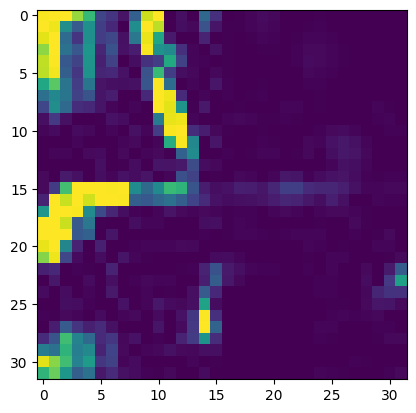

torch.Size([1, 1, 32, 32])
torch.Size([32, 32, 1])


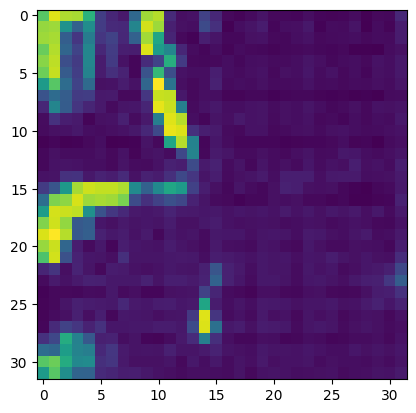

In [19]:
test_spec = Image.open("Data/SpectrogramsA/pop/pop_spec1.jpg")
make_tensor = torchvision.transforms.ToTensor()
test_spec = transform(test_spec)
test_spec = torch.transpose(test_spec, 0, 2)

fig, axs = plt.subplots(1)
axs.imshow(test_spec)
plt.show()


test_spec = torch.transpose(test_spec, 0, 2)
test_spec = torch.unsqueeze(test_spec, 0)
# test_spec = torch.transpose(test_spec, 0, 1)

print(test_spec.shape)
test1, test2 = slice_images(test_spec)
test_spec1 = generator(test1)
test_spec2 = generator(test2)
test_spec = assemble_images(test_spec1, test_spec2)

test_spec = torch.squeeze(test_spec, 0)
test_spec = torch.transpose(test_spec, 0, 2)

print(test_spec.shape)
fig, axs = plt.subplots(1)
axs.imshow(test_spec.detach())
plt.show()



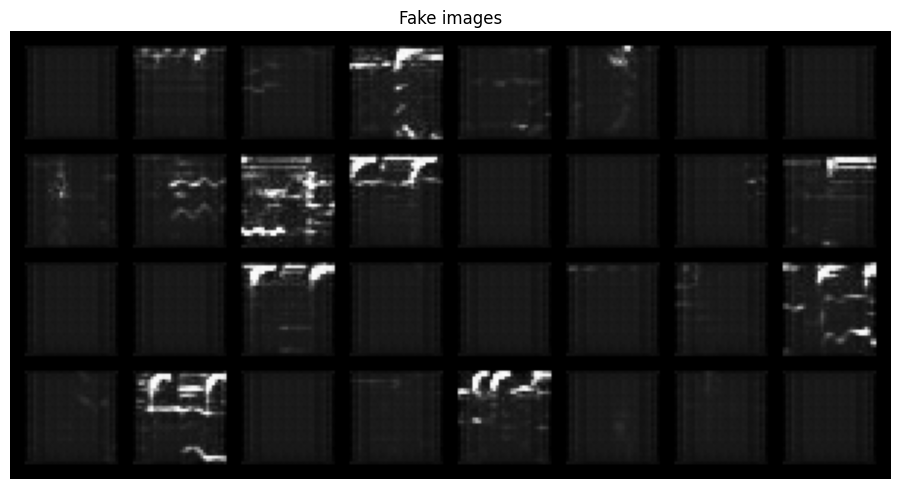

In [21]:
rock_batch = next(iter(dataloader_A))
p = rock_batch[0]
res = generator(p)
#b1, b2 = slice_images(rock_batch)
# p1 = generator(b1)
# p2 = generator(b2)
# p = assemble_images(p1, p2)

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(torchvision.utils.make_grid(res.to(device), padding=5, normalize=True).cpu(),(1,2,0)))



# plt.subplot()
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(res.detach(),(1,2,0)))
# plt.show()

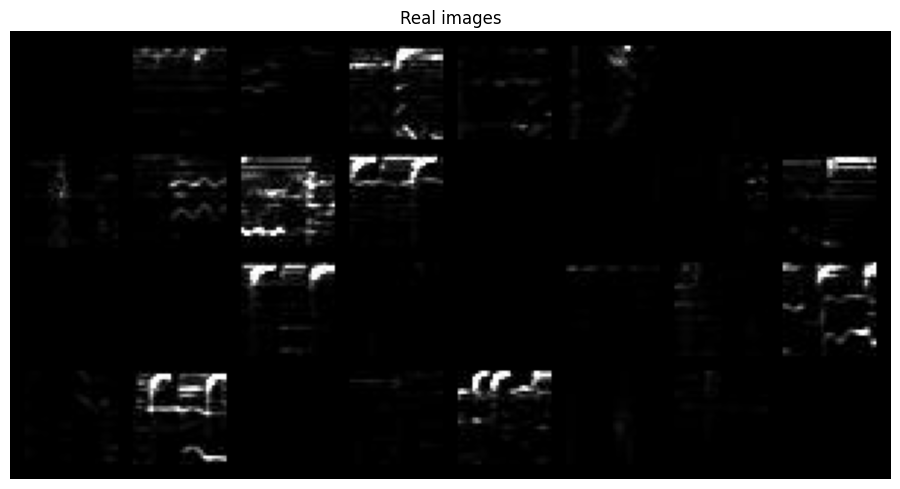

In [22]:
# real_batch = next(iter(dataloader))
real_batch = next(iter(dataloader_A))

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(torchvision.utils.make_grid(rock_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_lists[-1],(1,2,0)))
# plt.show()

In [ ]:
print("1")